In [3]:

import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import binomtest as binom_test
from datetime import datetime, timedelta
from pathlib import Path
from scipy.stats import t
import os
from scipy import stats
from scipy.stats import norm 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


Getting all the required data 

In [ ]:
Root_dir = ".."
Data_dir = os.path.join(Root_dir, "data_extraction", "raw_df")

def load_with_log_returns(csv_filename, lag=1):
    path = os.path.join(Data_dir, csv_filename)

    df = pd.read_csv(path)

    # Parse available date columns robustly
    for col in ['Date', 'Datetime']:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    # Prefer 'Date' as the index, otherwise use 'Datetime' if present
    if 'Date' in df.columns and not df['Date'].isna().all():
        df.set_index('Date', inplace=True)
    elif 'Datetime' in df.columns and not df['Datetime'].isna().all():
        df.set_index('Datetime', inplace=True)
    else:
        raise ValueError(
            f"CSV {path} must contain a 'Date' or 'Datetime' column. "
            f"Found: {list(df.columns)}"
        )

    # Detect the close-price column
    close_candidates = ['Close', 'Synthetic Index Close Price']
    price_col = None
    for c in close_candidates:
        if c in df.columns:
            price_col = c
            break

    if price_col is None:
        raise ValueError(
            f"CSV {path} must contain one of {close_candidates}. "
            f"Found: {list(df.columns)}"
        )

    # Compute log returns and log prices based on the detected price column
    price_series = df[price_col].astype(float)

    df['Log_Returns'] = np.log(price_series / price_series.shift(lag))
Log Prices – NASDAQ vs Synthetic ({title})
    return df

# ====== your existing indices (unchanged, still work if they use 'Close') ======
nasdaq_daily_df   = load_with_log_returns('nasdaq_daily_df.csv')
nasdaq_weekly_df  = load_with_log_returns('nasdaq_weekly_df.csv')
nasdaq_monthly_df = load_with_log_returns('nasdaq_monthly_df.csv')
nasdaq_hourly_df  = load_with_log_returns('nasdaq_hourly_df.csv')

nasdaq_daily_log_returns   = nasdaq_daily_df['Log_Returns'].dropna()
nasdaq_weekly_log_returns  = nasdaq_weekly_df['Log_Returns'].dropna()
nasdaq_monthly_log_returns = nasdaq_monthly_df['Log_Returns'].dropna()
nasdaq_hourly_log_returns  = nasdaq_hourly_df['Log_Returns'].dropna()

nasdaq_hourly_log_prices  = nasdaq_hourly_df['Log_Prices'].dropna()
nasdaq_daily_log_prices   = nasdaq_daily_df['Log_Prices'].dropna()
nasdaq_weekly_log_prices  = nasdaq_weekly_df['Log_Prices'].dropna()
nasdaq_monthly_log_prices = nasdaq_monthly_df['Log_Prices'].dropna()

# ====== synthetic indices (use 'Synthetic Index Close Price') ======
synthetic_price_daily_df   = load_with_log_returns('synthetic_price_daily_df.csv')
synthetic_price_weekly_df  = load_with_log_returns('synthetic_price_weekly_df.csv')
synthetic_price_monthly_df = load_with_log_returns('synthetic_price_monthly_df.csv')


synthetic_daily_log_returns   = synthetic_price_daily_df['Log_Returns'].dropna()
synthetic_weekly_log_returns  = synthetic_price_weekly_df['Log_Returns'].dropna()
synthetic_monthly_log_returns = synthetic_price_monthly_df['Log_Returns'].dropna()


synthetic_daily_log_prices   = synthetic_price_daily_df['Log_Prices'].dropna()
synthetic_weekly_log_prices  = synthetic_price_weekly_df['Log_Prices'].dropna()
synthetic_monthly_log_prices = synthetic_price_monthly_df['Log_Prices'].dropna()



/var/folders/k1/mhyzg0w15gb04d0x6q7gdp2w0000gn/T/ipykernel_38889/2391169046.py:23: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df[col] = pd.to_datetime(df[col], errors='coerce')
/var/folders/k1/mhyzg0w15gb04d0x6q7gdp2w0000gn/T/ipykernel_38889/2391169046.py:23: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df[col] = pd.to_datetime(df[col], errors='coerce')
/var/folders/k1/mhyzg0w15gb04d0x6q7gdp2w0000gn/T/ipykernel_38889/2391169046.py:23: Futur

Section 1 - Log prices time series plots

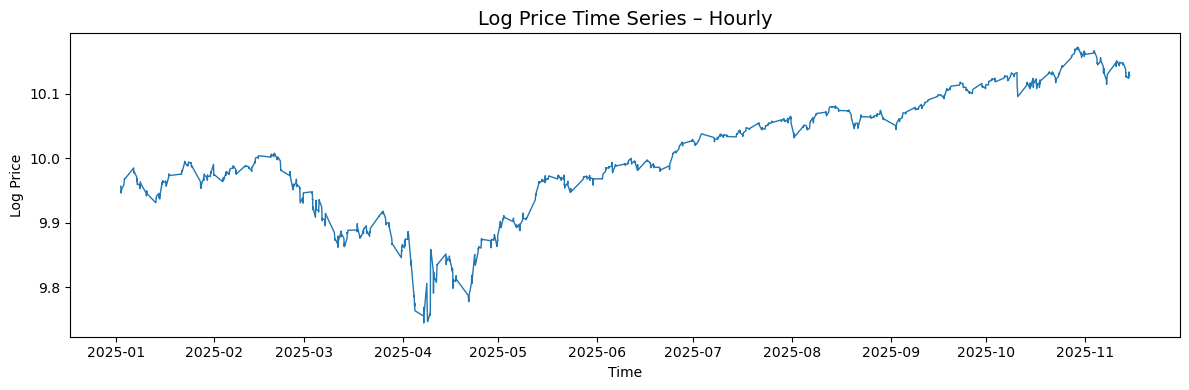

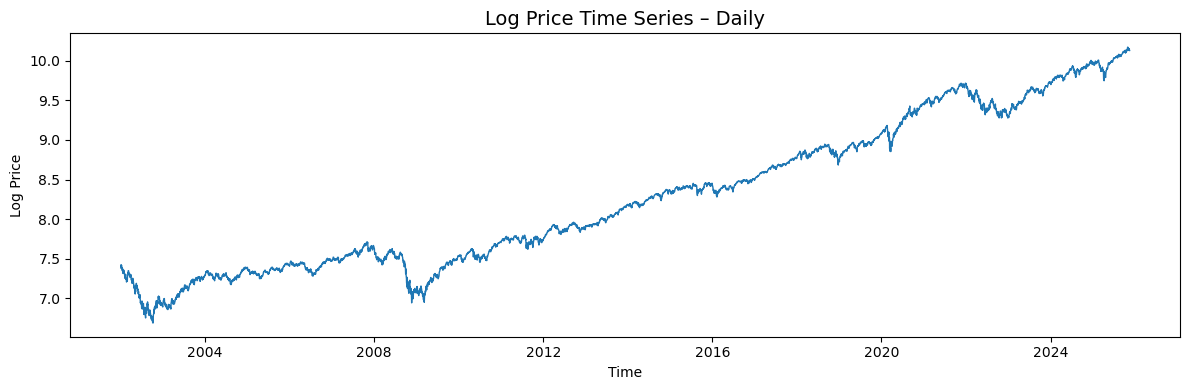

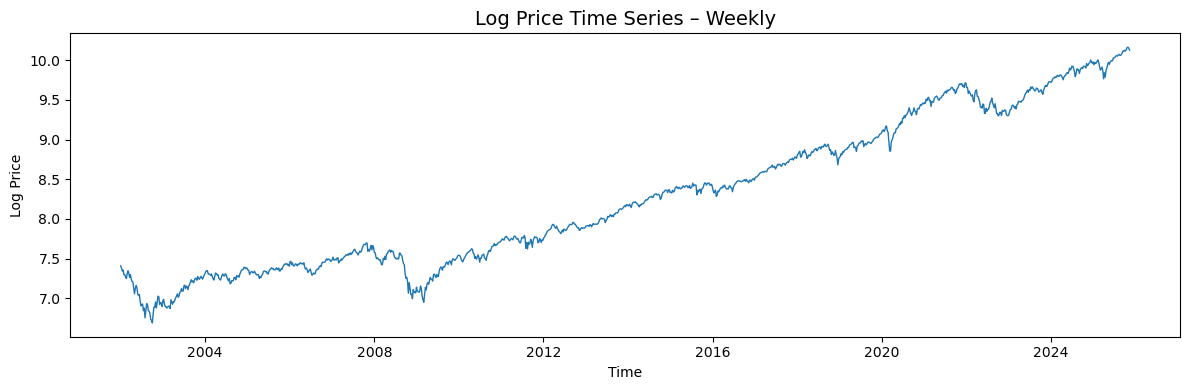

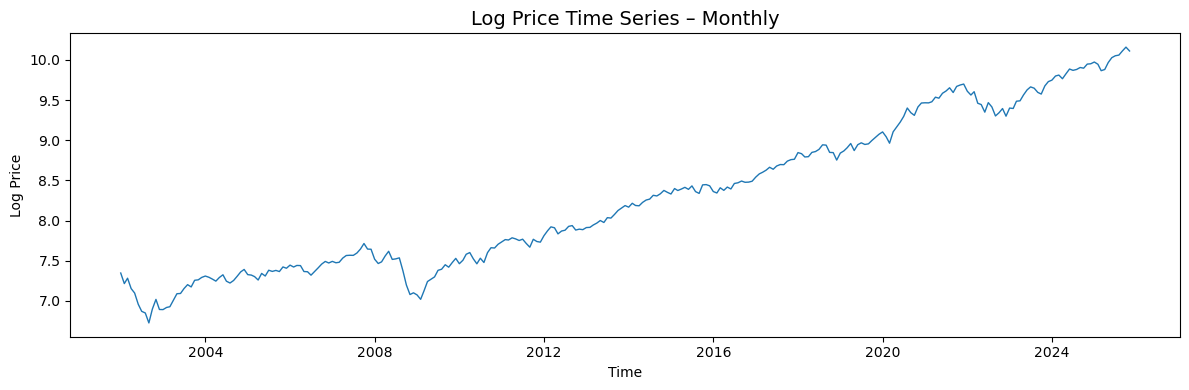

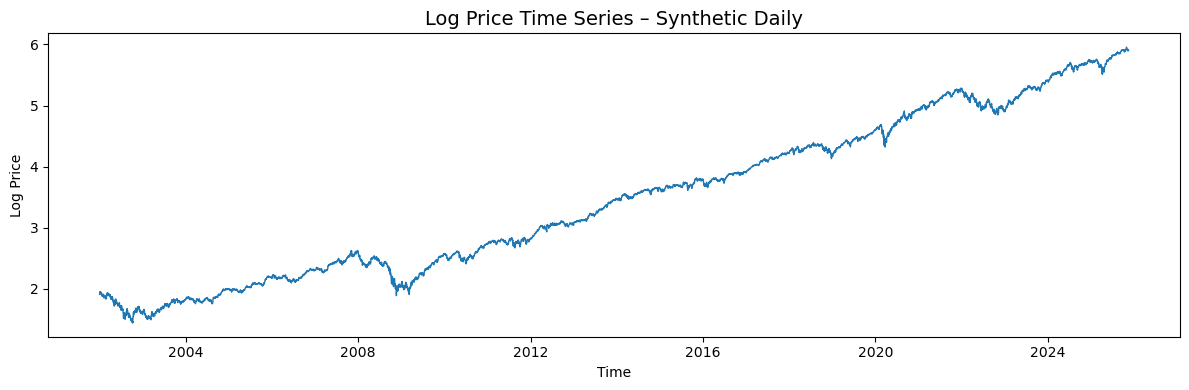

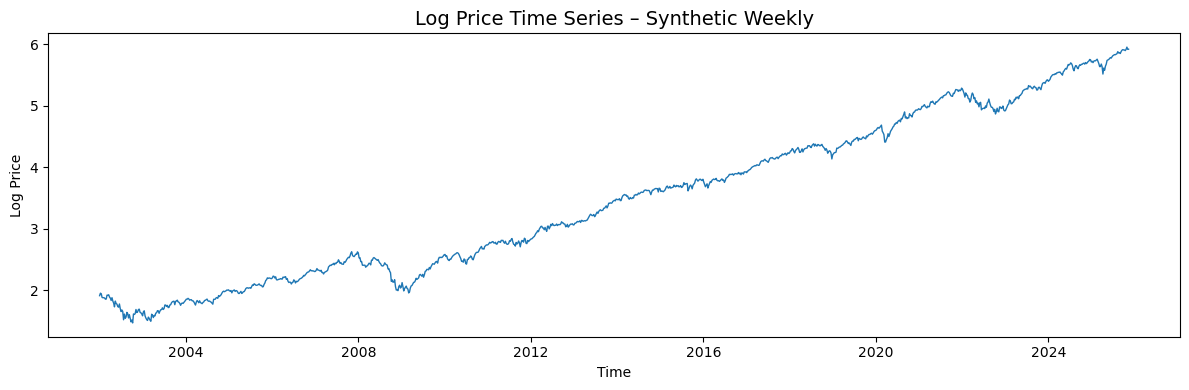

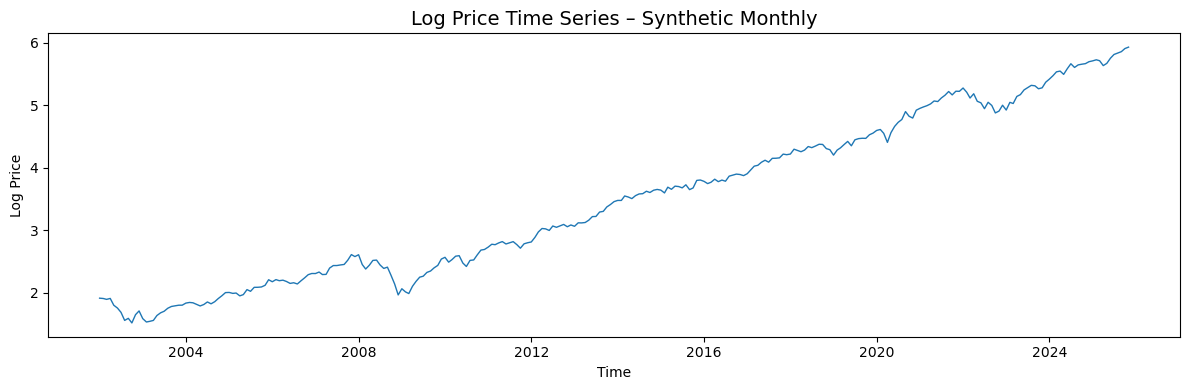

In [43]:
def plot_log_prices(obj, title, col=None):
    """
    obj : Series or DataFrame containing log prices.
    col : column name if obj is a DataFrame with multiple columns.
    """
    if isinstance(obj, pd.Series):
        series = obj
    elif isinstance(obj, pd.DataFrame):
        if col is None:
            if obj.shape[1] != 1:
                raise ValueError("DataFrame has multiple columns; please specify col='colname'.")
            series = obj.iloc[:, 0]
        else:
            series = obj[col]
    else:
        raise TypeError("obj must be a pandas Series or DataFrame")

    series = series.dropna()

    plt.figure(figsize=(12,4))
    plt.plot(series.index, series.values, linewidth=1)
    plt.title(f"Log Price Time Series – {title}", fontsize=14)
    plt.xlabel("Time")
    plt.ylabel("Log Price")
    plt.tight_layout()
    plt.show()
    
plot_log_prices(nasdaq_hourly_log_prices,  "Hourly")
plot_log_prices(nasdaq_daily_log_prices,   "Daily")
plot_log_prices(nasdaq_weekly_log_prices,  "Weekly")
plot_log_prices(nasdaq_monthly_log_prices, "Monthly")
plot_log_prices(synthetic_daily_log_prices, "Synthetic Daily")
plot_log_prices(synthetic_weekly_log_prices, "Synthetic Weekly")
plot_log_prices(synthetic_monthly_log_prices, "Synthetic Monthly")


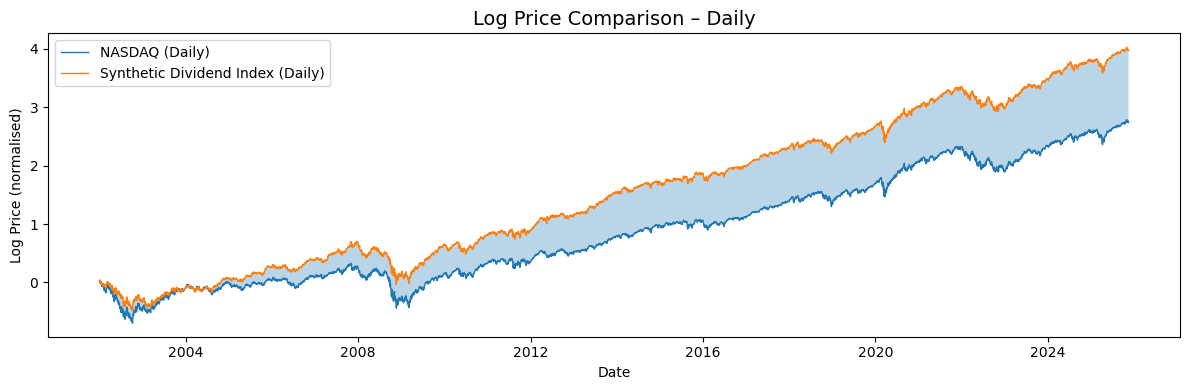

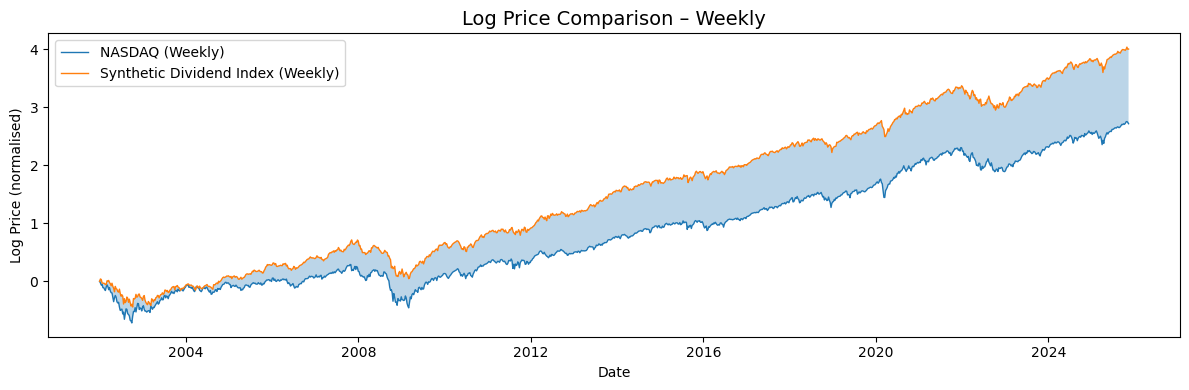

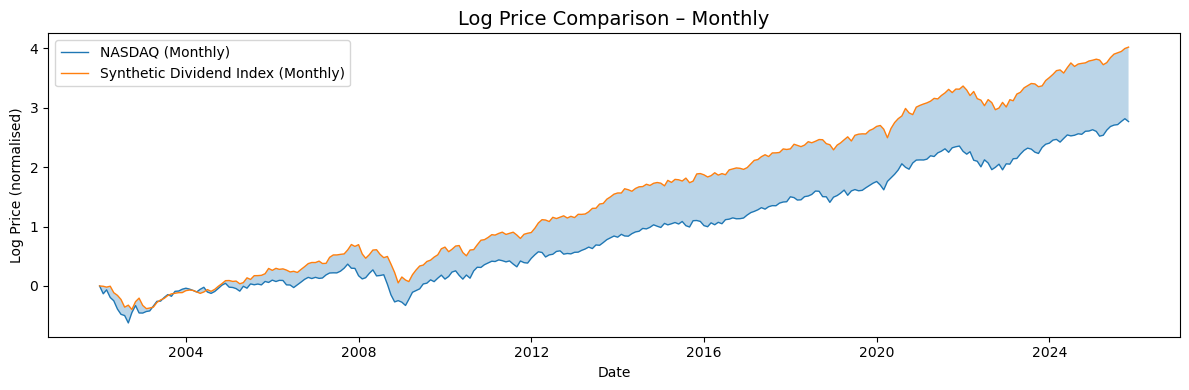

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# 1. BASIC HELPER: get a clean 1D Series from Series/DataFrame
# ============================================================

def _to_series(obj, col=None):
    """
    Convert a Series/DataFrame to a 1D Series, dropping NaNs.
    """
    if isinstance(obj, pd.Series):
        s = obj
    elif isinstance(obj, pd.DataFrame):
        if col is None:
            if obj.shape[1] != 1:
                raise ValueError("DataFrame has multiple columns; please specify col='colname'.")
            s = obj.iloc[:, 0]
        else:
            if col not in obj.columns:
                raise KeyError(
                    f"Column '{col}' not found in DataFrame. "
                    f"Available: {list(obj.columns)}"
                )
            s = obj[col]
    else:
        raise TypeError("obj must be a pandas Series or DataFrame")
    return s.dropna()


# =======================================================
# 2. HELPER: align any time index by *calendar date only*
# =======================================================

def _to_daily_series(obj, col=None):
    """
    Take a Series/DataFrame with ANY kind of time index (tz-aware, tz-naive,
    strings with offsets, etc.) and return a Series indexed by calendar DATE.
    If there are multiple observations per date, keep the last one.
    """
    s = _to_series(obj, col=col).copy()

    # Robust conversion: handle tz-aware and tz-naive uniformly
    # utc=True makes tz-aware safe; then we drop tz and keep just dates
    idx = pd.to_datetime(s.index, utc=True, errors="coerce")

    # Drop anything that couldn't be parsed as datetime
    mask = ~idx.isna()
    s = s[mask]
    idx = idx[mask]

    # Use calendar dates as index
    date_index = pd.Index(idx.date, name="date")
    s = pd.Series(s.values, index=date_index)

    # If multiple obs per date, keep the last
    s = s.groupby(level=0).last()

    return s


# ==========================================
# 3. PLOT COMPARISON WITH SHADED DIFFERENCE
# ==========================================

def plot_log_price_comparison(
    obj1,
    obj2,
    label1,
    label2,
    title,
    col1=None,
    col2=None,
    normalize=True
):
    """
    Plot two log price series on the same figure for comparison,
    with shaded area between them.

    Alignment is done by calendar DATE (not exact timestamp),
    so it is robust to time zones and different intraday times.
    """
    # Convert both to daily series on date index
    s1 = _to_daily_series(obj1, col=col1)
    s2 = _to_daily_series(obj2, col=col2)

    # Align on common calendar dates
    df = pd.concat([s1, s2], axis=1, join="inner")
    df.columns = [label1, label2]
    df = df.dropna()

    if df.empty:
        raise ValueError(
            "No overlapping calendar dates between the two series after alignment. "
            "Check that they actually cover some common period."
        )

    # Optionally normalise so both start at 0 (relative performance)
    if normalize:
        df = df - df.iloc[0]

    plt.figure(figsize=(12, 4))

    # Plot the two lines
    plt.plot(df.index, df[label1], linewidth=1, label=label1)
    plt.plot(df.index, df[label2], linewidth=1, label=label2)

    # Shade the difference between them
    plt.fill_between(
        df.index,
        df[label1],
        df[label2],
        alpha=0.3
    )

    plt.title(f"Log Price Comparison – {title}", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Log Price (normalised)" if normalize else "Log Price")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ==========================================
# 4. EXAMPLE CALLS (ASSUMES THESE OBJECTS EXIST):
#    nasdaq_*_log_prices and synthetic_*_log_prices
# ==========================================

# Daily
plot_log_price_comparison(
    nasdaq_daily_log_prices,
    synthetic_daily_log_prices,
    label1="NASDAQ (Daily)",
    label2="Synthetic Dividend Index (Daily)",
    title="Daily"
)

# Weekly
plot_log_price_comparison(
    nasdaq_weekly_log_prices,
    synthetic_weekly_log_prices,
    label1="NASDAQ (Weekly)",
    label2="Synthetic Dividend Index (Weekly)",
    title="Weekly"
)

# Monthly
plot_log_price_comparison(
    nasdaq_monthly_log_prices,
    synthetic_monthly_log_prices,
    label1="NASDAQ (Monthly)",
    label2="Synthetic Dividend Index (Monthly)",
    title="Monthly"
)


In [39]:
print(type(nasdaq_daily_log_prices.index))
print(type(synthetic_daily_log_prices.index))

print(nasdaq_daily_log_prices.index.min(), nasdaq_daily_log_prices.index.max())
print(synthetic_daily_log_prices.index.min(), synthetic_daily_log_prices.index.max())

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
<class 'pandas.core.indexes.base.Index'>
2002-01-02 00:00:00 2025-11-14 00:00:00
2002-01-01 00:00:00-05:00 2025-11-15 00:00:00-05:00


Dividend Extraction 

In [16]:
Root_dir = ".."
Data_dir = os.path.join(Root_dir, "data_extraction", "raw_df")

# ================================
# Generic loader for dividends & risk-free (robust column detection)
# ================================
def load_series_with_logs(csv_filename, value_col, date_cols=('Date','Datetime')):
    """
    Robust loader that:
      - parses 'Date' or 'Datetime' as index (if present)
      - detects the value column flexibly (accepts exact, list of names, or heuristics)
      - coerces to numeric
      - computes Log_Value and Log_Returns while avoiding log(0)/inf
    """
    path = os.path.join(Data_dir, csv_filename)
    df = pd.read_csv(path)

    # ---- Handle date parsing ----
    for col in date_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    if 'Date' in df.columns and not df['Date'].isna().all():
        df.set_index('Date', inplace=True)
    elif 'Datetime' in df.columns and not df['Datetime'].isna().all():
        df.set_index('Datetime', inplace=True)
    else:
        raise ValueError(f"{csv_filename} missing Date/Datetime. Found {list(df.columns)}")

    # ---- Flexible detection of value column ----
    # allow value_col to be a single name or an iterable of candidates
    if isinstance(value_col, (list, tuple, set)):
        candidates = list(value_col)
    else:
        candidates = [value_col]

    def _norm(s):
        return str(s).lower().replace('–', '-').replace('—', '-').strip()

    cols_norm = { _norm(c): c for c in df.columns }

    chosen_col = None
    # try exact (normalized) matches first
    for cand in candidates:
        nc = _norm(cand)
        if nc in cols_norm:
            chosen_col = cols_norm[nc]
            break

    # fallback: look for obvious keywords if exact not found
    if chosen_col is None:
        keywords = ['yield', 'treasury', '1-month', '1 month', '1m', 'rate', 'dividend']
        for col in df.columns:
            lc = str(col).lower()
            if any(kw in lc for kw in keywords):
                chosen_col = col
                break

    # last resort: pick the single numeric column (if only one exists)
    if chosen_col is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if len(numeric_cols) == 1:
            chosen_col = numeric_cols[0]

    if chosen_col is None:
        raise KeyError(
            f"Could not find value column for '{value_col}' in {csv_filename}. "
            f"Available columns: {list(df.columns)}"
        )

    if chosen_col != value_col:
        # small informative message (won't break notebooks); change to print if desired
        print(f"[load_series_with_logs] Using column '{chosen_col}' for '{csv_filename}' (requested '{value_col}').")

    # ---- Ensure numeric ----
    df[chosen_col] = pd.to_numeric(df[chosen_col], errors='coerce')

    # ---- Compute logs and returns avoiding log(0) and infs ----
    series = df[chosen_col]
    series_nonzero = series.replace(0, np.nan)

    df['Log_Value'] = np.log(series_nonzero)  # log of level, NaN if zero/missing

    # compute log-returns safely: if previous is zero/missing, result is NaN
    prev = series_nonzero.shift(1)
    with np.errstate(divide='ignore', invalid='ignore'):
        lr = np.log(series_nonzero / prev)

    # replace infinities with NaN
    lr = pd.Series(lr, index=df.index).replace([np.inf, -np.inf], np.nan)
    df['Log_Returns'] = lr

    return df


# ================================
# Dividend loaders
# ================================
synthetic_div_daily_df   = load_series_with_logs(
    "synthetic_div_daily_df.csv",
    "Synthetic Index Dividend"
)
synthetic_div_weekly_df  = load_series_with_logs(
    "synthetic_div_weekly_df.csv",
    "Synthetic Index Dividend"
)
synthetic_div_monthly_df = load_series_with_logs(
    "synthetic_div_monthly_df.csv",
    "Synthetic Index Dividend"
)

# Extract ready-to-use series
synthetic_div_daily_log_div      = synthetic_div_daily_df['Log_Returns'].dropna()
synthetic_div_weekly_log_div     = synthetic_div_weekly_df['Log_Returns'].dropna()
synthetic_div_monthly_log_div    = synthetic_div_monthly_df['Log_Returns'].dropna()

synthetic_div_daily_log_levels   = synthetic_div_daily_df['Log_Value'].dropna()
synthetic_div_weekly_log_levels  = synthetic_div_weekly_df['Log_Value'].dropna()
synthetic_div_monthly_log_levels = synthetic_div_monthly_df['Log_Value'].dropna()


# ================================
# Risk-free loaders
# ================================
risk_free_daily_df = load_series_with_logs(
    "risk_free_daily_df.csv",
    "1-month Yield – US Treasury Securities"
)
risk_free_weekly_df = load_series_with_logs(
    "risk_free_weekly_df.csv",
    "1-month Yield – US Treasury Securities"
)
risk_free_monthly_df = load_series_with_logs(
    "risk_free_monthly_df.csv",
    "1-month Yield – US Treasury Securities"
)

risk_free_daily_log_rf   = risk_free_daily_df['Log_Value'].dropna()
risk_free_weekly_log_rf  = risk_free_weekly_df['Log_Value'].dropna()
risk_free_monthly_log_rf = risk_free_monthly_df['Log_Value'].dropna()


[load_series_with_logs] Using column '1-month Yield - US Treasury Securities' for 'risk_free_daily_df.csv' (requested '1-month Yield – US Treasury Securities').
[load_series_with_logs] Using column '1-month Yield - US Treasury Securities' for 'risk_free_weekly_df.csv' (requested '1-month Yield – US Treasury Securities').
[load_series_with_logs] Using column '1-month Yield - US Treasury Securities' for 'risk_free_monthly_df.csv' (requested '1-month Yield – US Treasury Securities').


/var/folders/k1/mhyzg0w15gb04d0x6q7gdp2w0000gn/T/ipykernel_38889/1276000542.py:21: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df[col] = pd.to_datetime(df[col], errors='coerce')
/var/folders/k1/mhyzg0w15gb04d0x6q7gdp2w0000gn/T/ipykernel_38889/1276000542.py:21: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df[col] = pd.to_datetime(df[col], errors='coerce')
/var/folders/k1/mhyzg0w15gb04d0x6q7gdp2w0000gn/T/ipykernel_38889/1276000542.py:21: Futur

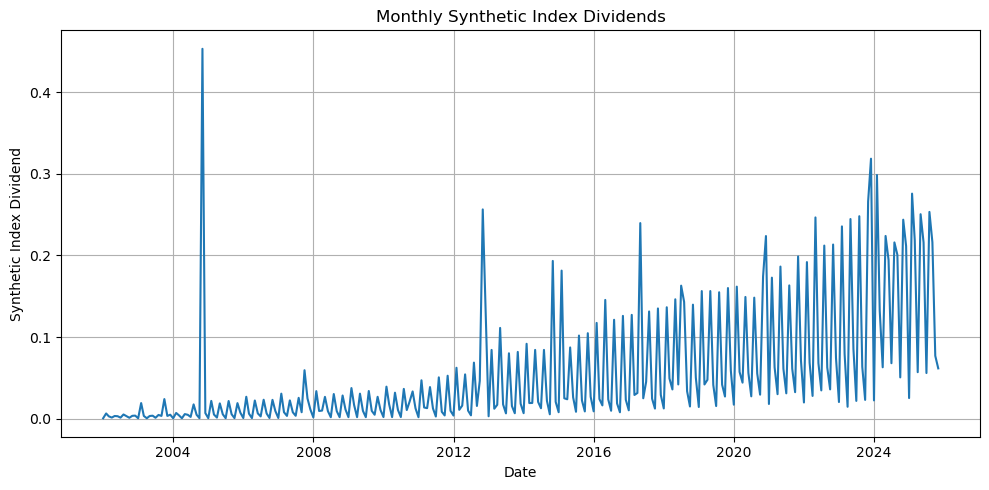

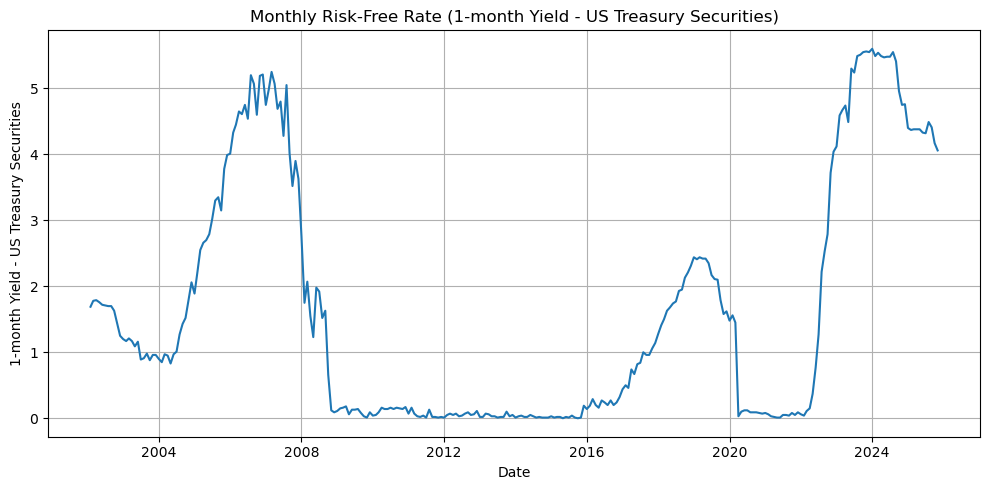

In [18]:
# Plot Monthly Synthetic Dividends (robust column selection)
div_col = "Synthetic Index Dividend" if "Synthetic Index Dividend" in synthetic_div_monthly_df.columns else synthetic_div_monthly_df.columns[0]

plt.figure(figsize=(10, 5))
plt.plot(
    synthetic_div_monthly_df.index,
    synthetic_div_monthly_df[div_col],
    label="Monthly Dividends"
)
plt.title("Monthly Synthetic Index Dividends")
plt.xlabel("Date")
plt.ylabel(div_col)
plt.grid(True)
plt.tight_layout()
plt.show()

rf_candidates = [c for c in risk_free_monthly_df.columns if any(k in c.lower() for k in ("yield", "treasury", "rate", "1-month", "1 month", "1m"))]
rf_col = rf_candidates[0] if rf_candidates else risk_free_monthly_df.columns[0]

plt.figure(figsize=(10, 5))
plt.plot(
    risk_free_monthly_df.index,
    risk_free_monthly_df[rf_col],
    label="Monthly Risk-Free Rate"
)
plt.title(f"Monthly Risk-Free Rate ({rf_col})")
plt.xlabel("Date")
plt.ylabel(rf_col)
plt.grid(True)
plt.tight_layout()
plt.show()

Log Returns - Prices 1st Difference PLot --> WN plot

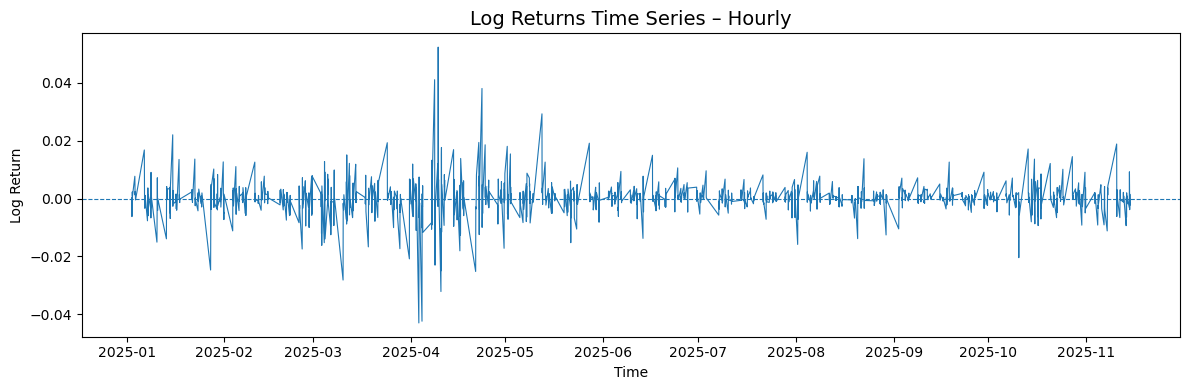

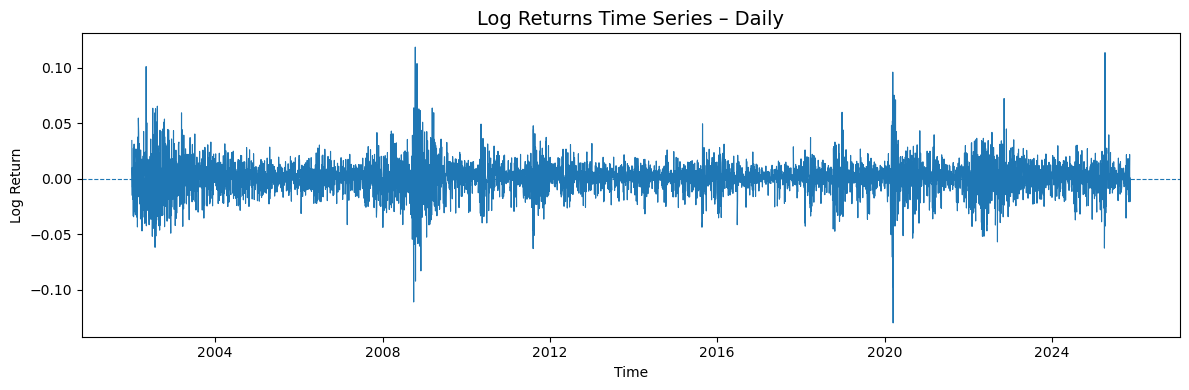

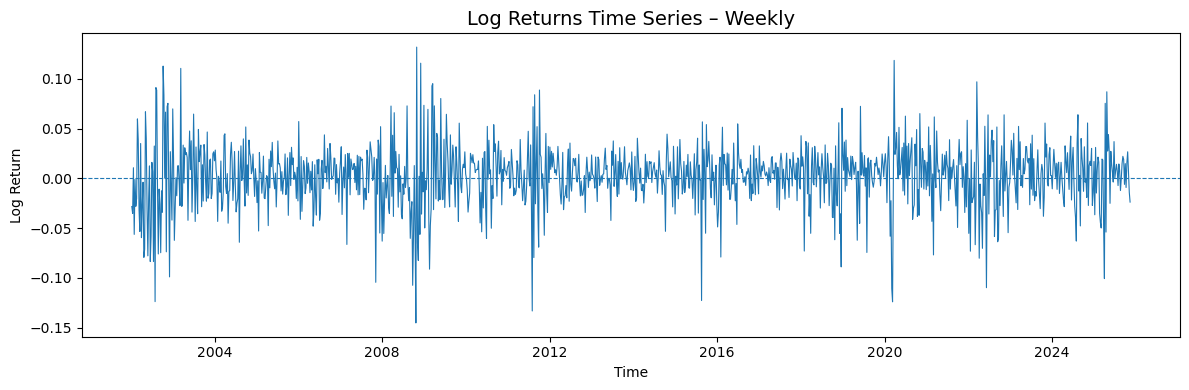

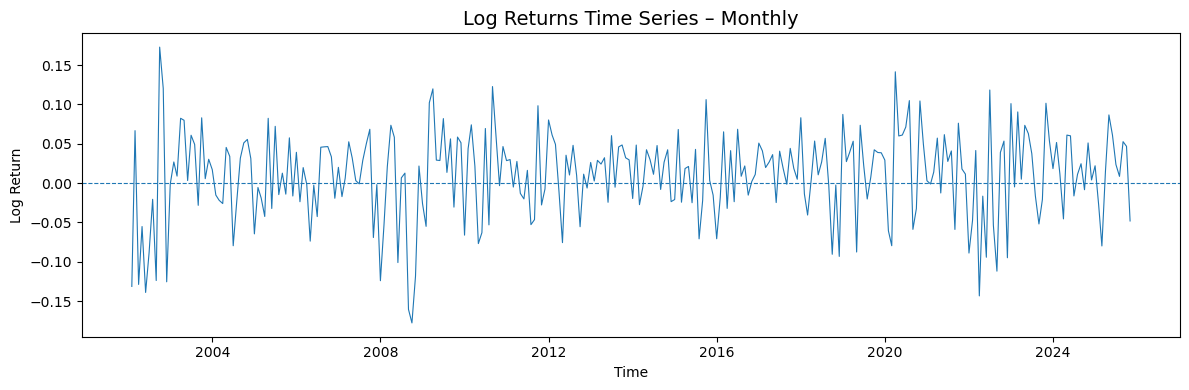

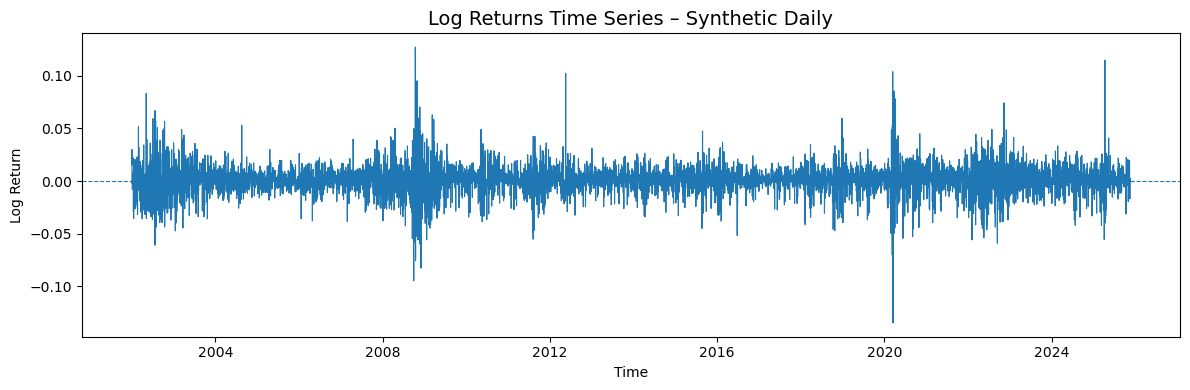

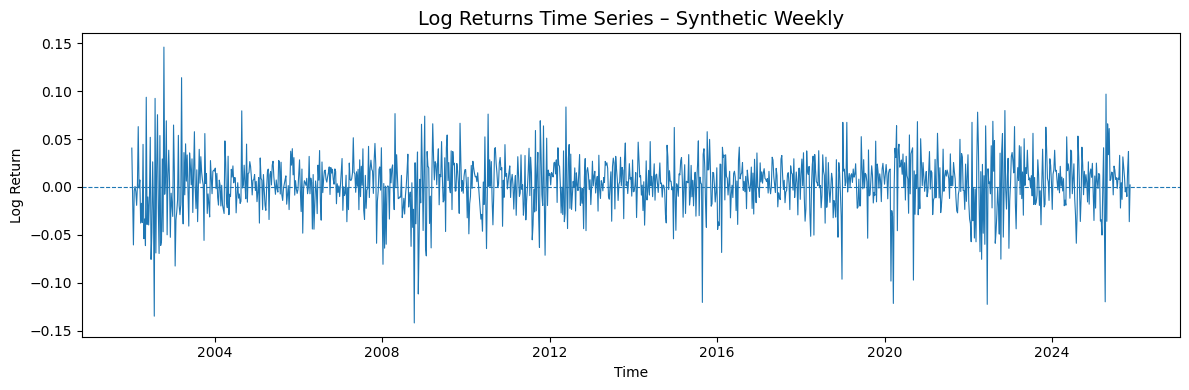

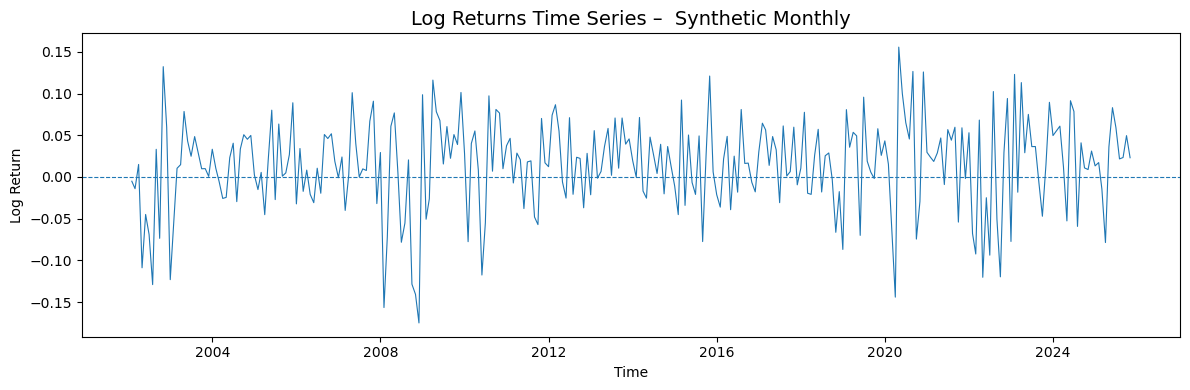

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_log_returns(obj, title, col=None):
    """
    obj : pd.Series or pd.DataFrame
        - If Series: it is assumed to be the log-returns.
        - If DataFrame: you must either pass col, or it must have exactly 1 column.
    col : str or None
        Column name if obj is a DataFrame with multiple columns.
    """
    # --- Extract the Series y ---
    if isinstance(obj, pd.Series):
        y = obj
    elif isinstance(obj, pd.DataFrame):
        if col is not None:
            y = obj[col]
        else:
            # If no column given, try to use the only column
            if obj.shape[1] != 1:
                raise ValueError(
                    "DataFrame has multiple columns; please specify 'col='."
                )
            y = obj.iloc[:, 0]
    else:
        raise TypeError("obj must be a pandas Series or DataFrame")

    # --- Plot ---
    plt.figure(figsize=(12, 4))
    plt.plot(y.index, y.values, linewidth=0.8)
    plt.axhline(0, linestyle="--", linewidth=0.8)
    plt.title(f"Log Returns Time Series – {title}", fontsize=14)
    plt.xlabel("Time")
    plt.ylabel("Log Return")
    plt.tight_layout()
    plt.show()

plot_log_returns(nasdaq_hourly_log_returns,  "Hourly")
plot_log_returns(nasdaq_daily_log_returns,   "Daily")
plot_log_returns(nasdaq_weekly_log_returns,  "Weekly")
plot_log_returns(nasdaq_monthly_log_returns, "Monthly")
plot_log_returns(synthetic_daily_log_returns, "Synthetic Daily")
plot_log_returns(synthetic_weekly_log_returns, "Synthetic Weekly")
plot_log_returns(synthetic_monthly_log_returns, " Synthetic Monthly")


Histogram of Returns + Normal PDF Overlay

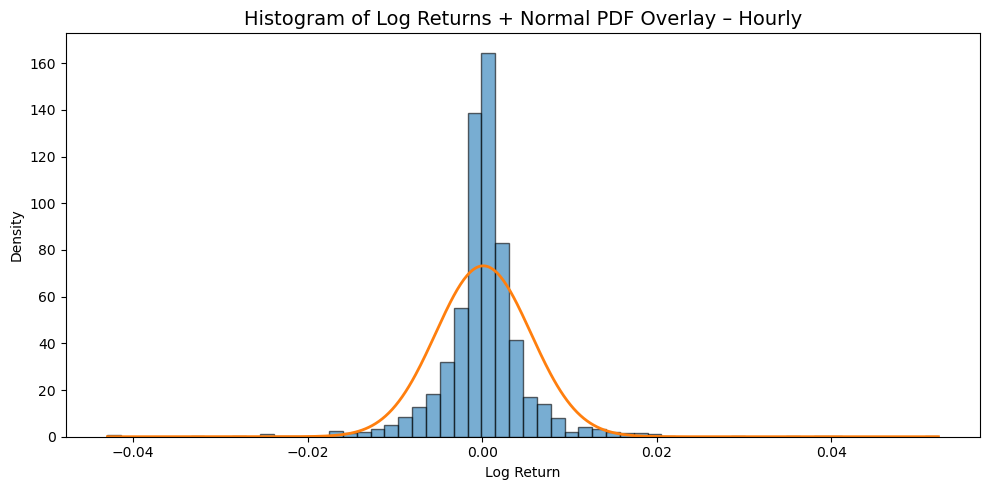

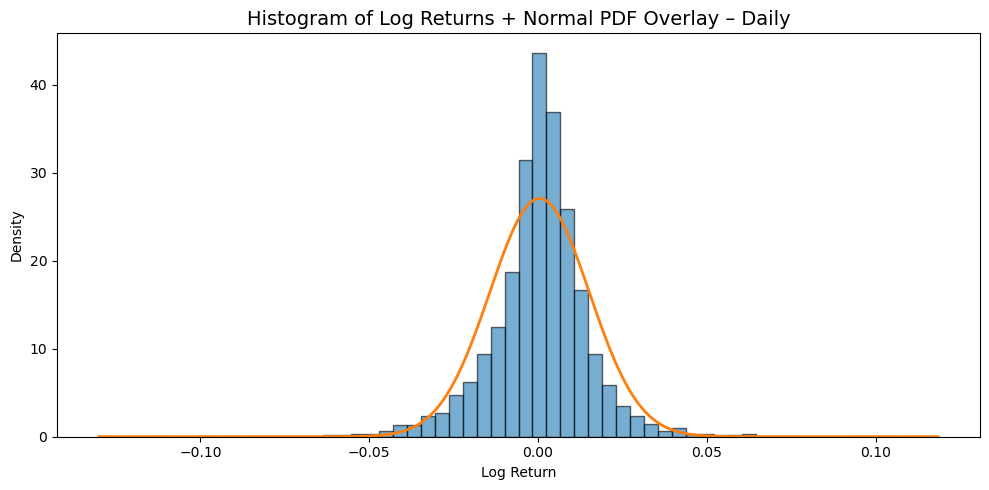

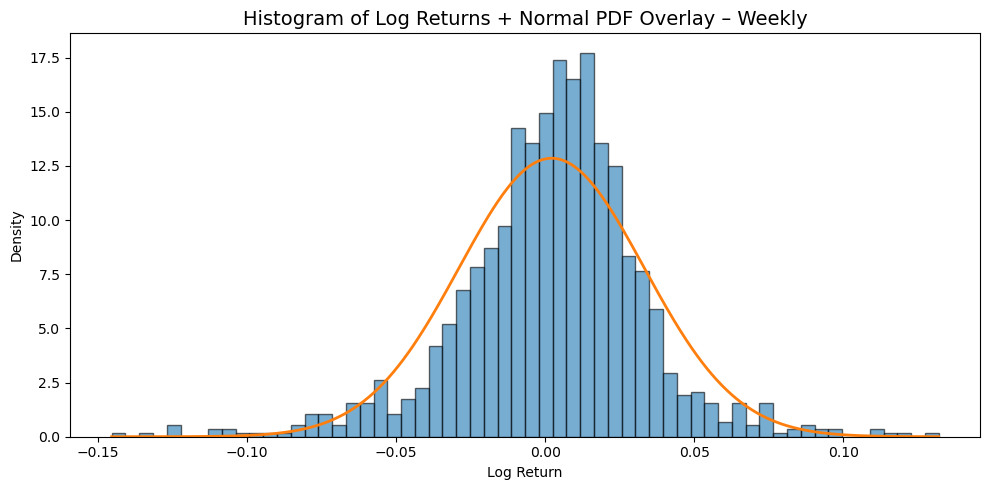

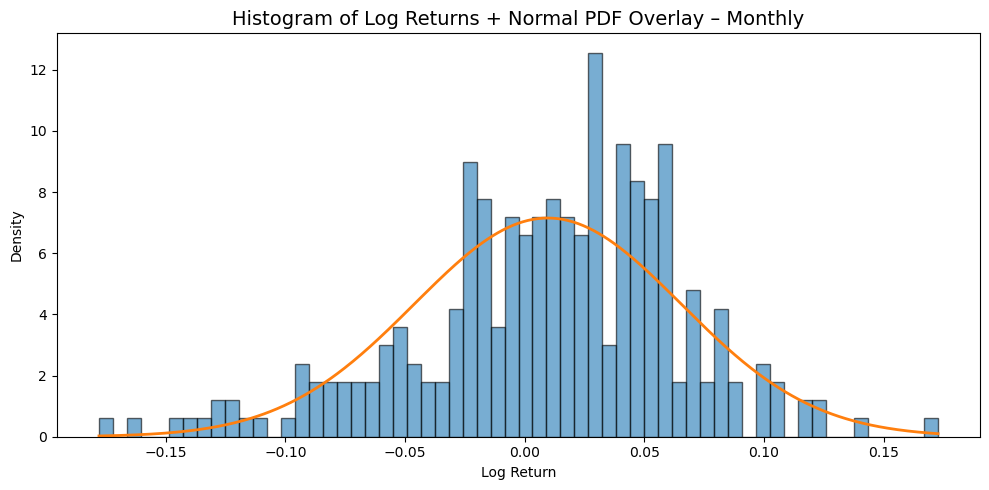

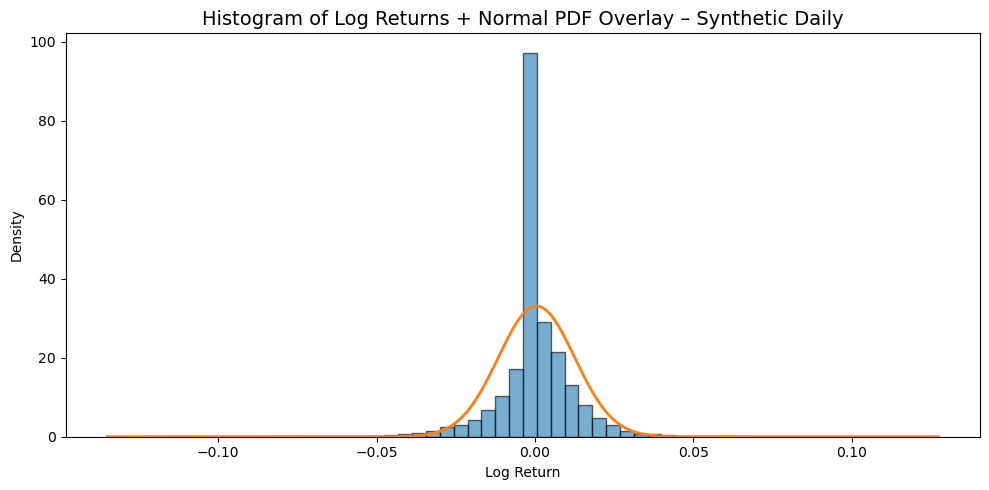

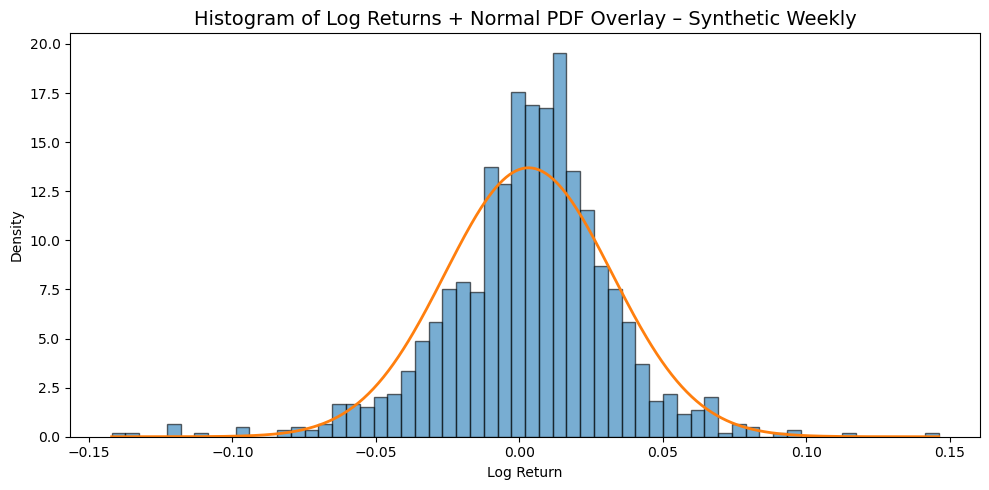

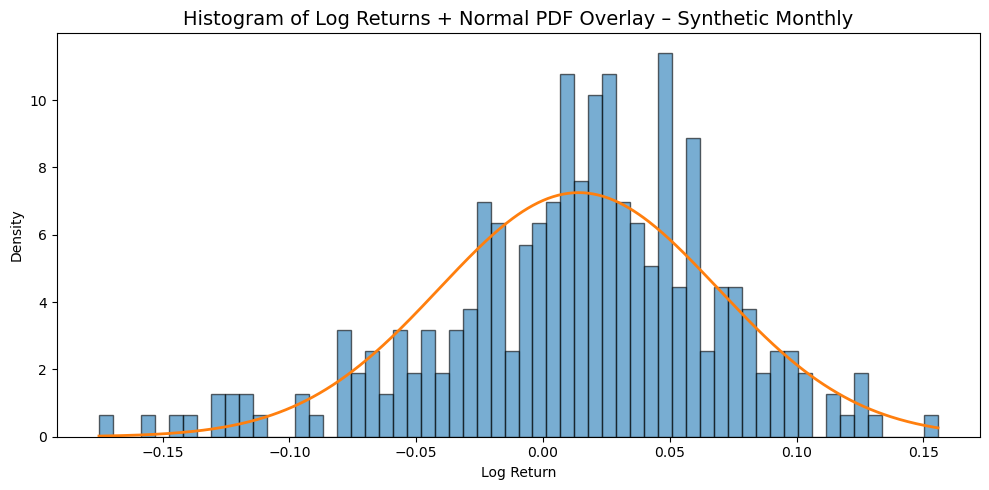

In [9]:
# Histogram of Returns + Normal PDF Overlay
def plot_return_histogram(obj, title, col=None, bins=60):
    """
    obj : Series or DataFrame of returns
    col : column name if obj is a DataFrame with multiple columns
    """
    # --- Extract the series ---
    if isinstance(obj, pd.Series):
        r = obj.dropna()
    elif isinstance(obj, pd.DataFrame):
        if col is None:
            if obj.shape[1] != 1:
                raise ValueError("DataFrame has multiple columns. Provide col='colname'.")
            r = obj.iloc[:, 0].dropna()
        else:
            r = obj[col].dropna()
    else:
        raise TypeError("obj must be a pandas Series or DataFrame")

    # --- Fit normal distribution ---
    mu, sigma = r.mean(), r.std()

    # --- Plot ---
    plt.figure(figsize=(10, 5))
    
    # Histogram (density)
    plt.hist(r, bins=bins, density=True, alpha=0.6, edgecolor="black")

    # Normal PDF overlay
    x_vals = np.linspace(r.min(), r.max(), 500)
    pdf_vals = norm.pdf(x_vals, mu, sigma)
    plt.plot(x_vals, pdf_vals, linewidth=2)

    # Title & labels
    plt.title(f"Histogram of Log Returns + Normal PDF Overlay – {title}", fontsize=14)
    plt.xlabel("Log Return")
    plt.ylabel("Density")
    
    plt.tight_layout()
    plt.show()
    
plot_return_histogram(nasdaq_hourly_log_returns,  "Hourly",  col="Log_Returns")
plot_return_histogram(nasdaq_daily_log_returns,   "Daily",   col="Log_Returns")
plot_return_histogram(nasdaq_weekly_log_returns,  "Weekly",  col="Log_Returns")
plot_return_histogram(nasdaq_monthly_log_returns, "Monthly", col="Log_Returns")
plot_return_histogram(synthetic_daily_log_returns, "Synthetic Daily", col = "Log_Returns")
plot_return_histogram(synthetic_weekly_log_returns, "Synthetic Weekly", col= "Log_Returns")
plot_return_histogram(synthetic_monthly_log_returns, "Synthetic Monthly", col = "Log_Returns")



QQ Plot Returns

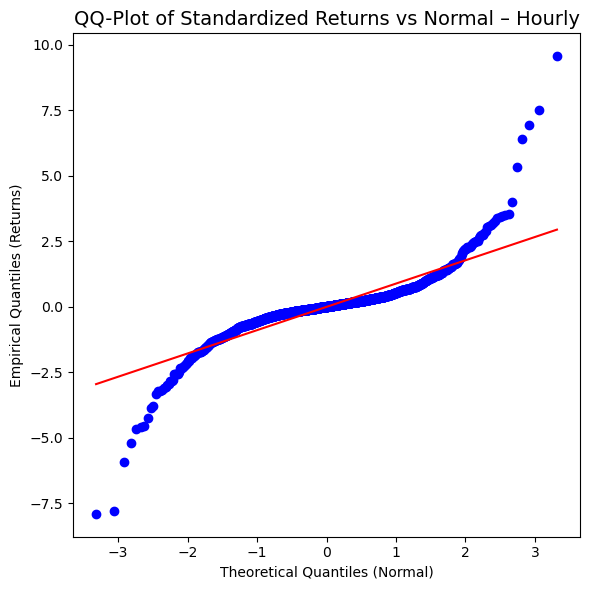

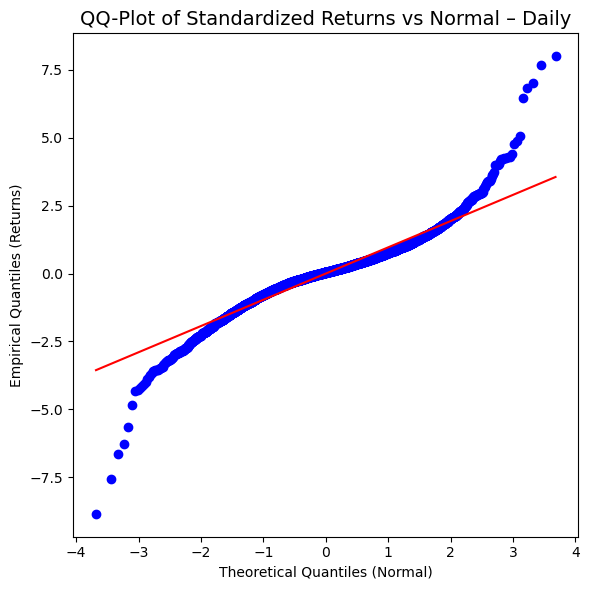

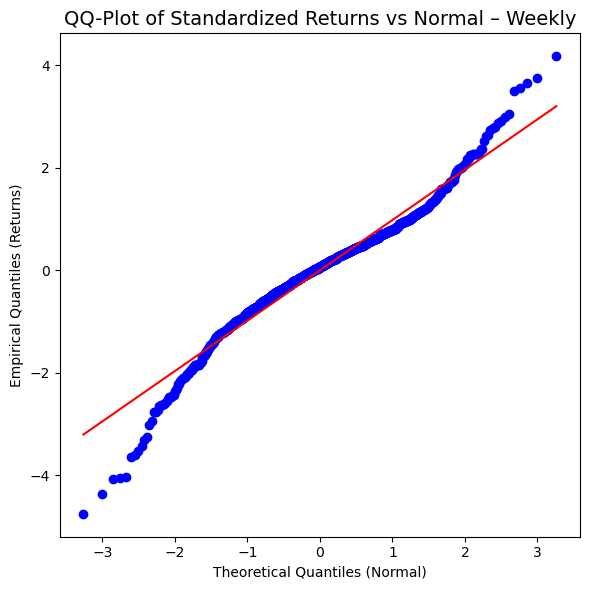

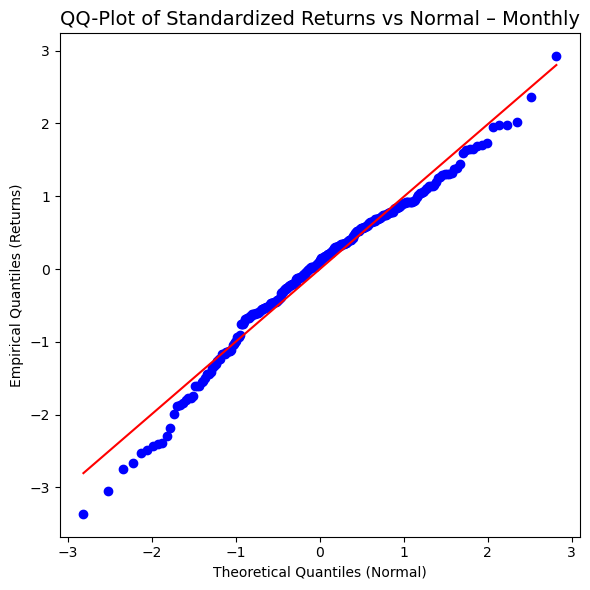

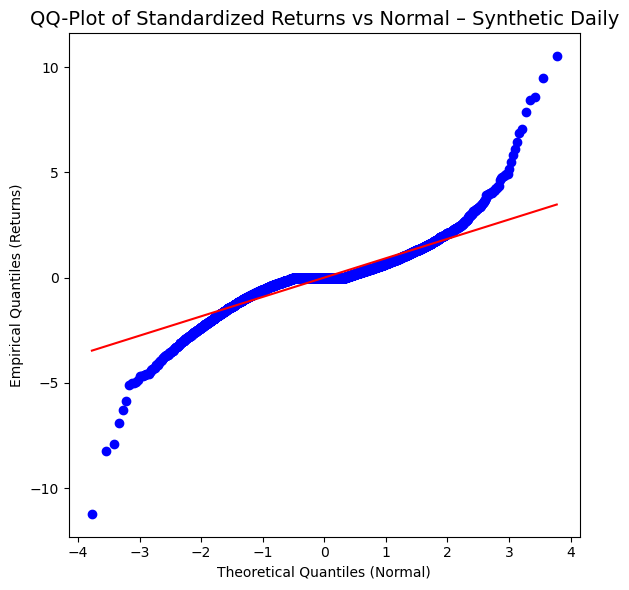

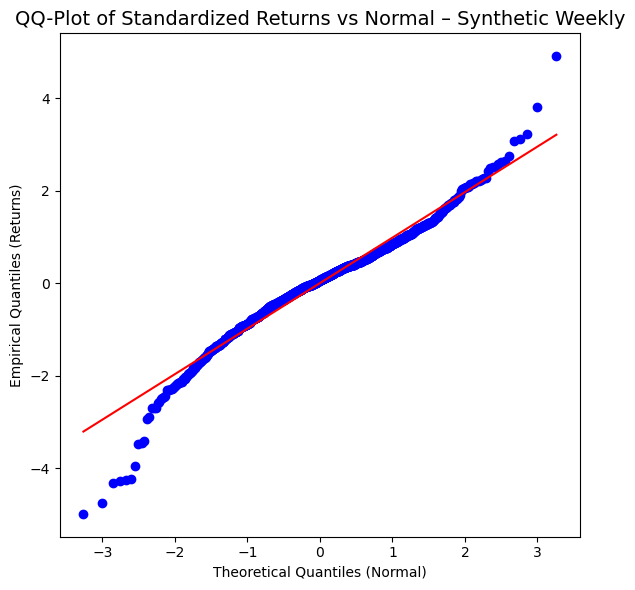

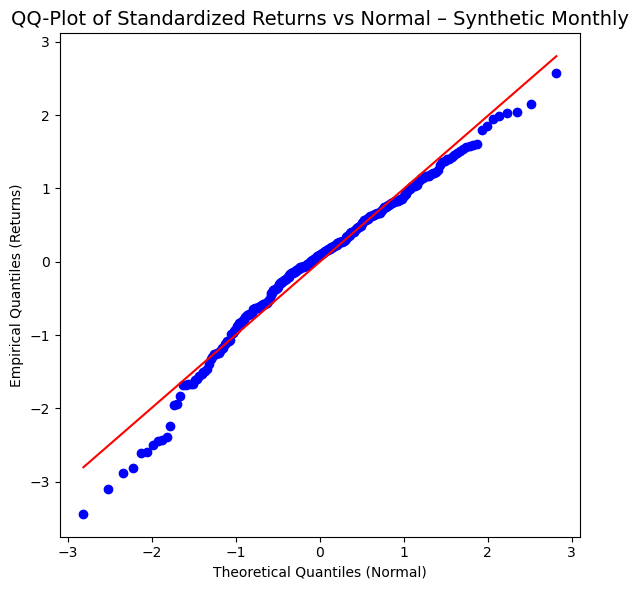

In [10]:
def plot_return_qq(obj, title, col=None):
    """
    QQ-plot of returns vs Normal(μ, σ).
    
    obj : pd.Series or pd.DataFrame
        - If Series: taken as the returns.
        - If DataFrame: use 'col' or the only column.
    col : str or None
        Column name if obj is a DataFrame with multiple columns.
    """
    # --- Extract the series ---
    if isinstance(obj, pd.Series):
        r = obj.dropna()
    elif isinstance(obj, pd.DataFrame):
        if col is None:
            if obj.shape[1] != 1:
                raise ValueError("DataFrame has multiple columns; please specify col='colname'.")
            r = obj.iloc[:, 0].dropna()
        else:
            r = obj[col].dropna()
    else:
        raise TypeError("obj must be a pandas Series or DataFrame")
    
    # Standardize returns to compare shape (tails) only
    r_std = (r - r.mean()) / r.std()

    # --- QQ-plot ---
    plt.figure(figsize=(6, 6))
    # stats.probplot returns theoretical quantiles + ordered values; plot param draws it
    stats.probplot(r_std, dist="norm", plot=plt)
    plt.title(f"QQ-Plot of Standardized Returns vs Normal – {title}", fontsize=14)
    plt.xlabel("Theoretical Quantiles (Normal)")
    plt.ylabel("Empirical Quantiles (Returns)")
    plt.tight_layout()
    plt.show()
    

plot_return_qq(nasdaq_hourly_log_returns,  "Hourly",  col="Log_Returns")
plot_return_qq(nasdaq_daily_log_returns,   "Daily",   col="Log_Returns")
plot_return_qq(nasdaq_weekly_log_returns,  "Weekly",  col="Log_Returns")
plot_return_qq(nasdaq_monthly_log_returns, "Monthly", col="Log_Returns")
plot_return_qq(synthetic_daily_log_returns,   "Synthetic Daily",   col="Log_Returns")
plot_return_qq(synthetic_weekly_log_returns,  "Synthetic Weekly",  col="Log_Returns")
plot_return_qq(synthetic_monthly_log_returns, "Synthetic Monthly", col="Log_Returns")




Mean Return with 95% CI Plot (Bar Plot)

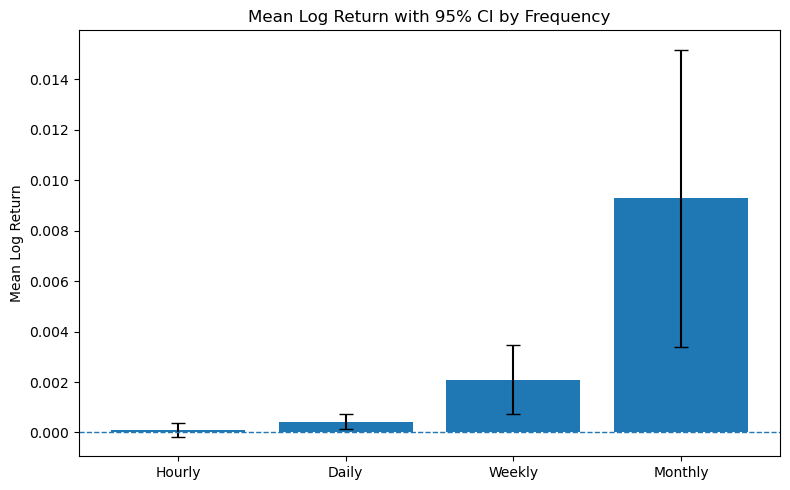

In [ ]:
def extract_series(obj, col=None):
    """
    Helper: take a Series or DataFrame and return a 1D Series of returns.
    """
    if isinstance(obj, pd.Series):
        return obj.dropna()
    elif isinstance(obj, pd.DataFrame):
        if col is None:
            if obj.shape[1] != 1:
                raise ValueError("DataFrame has multiple columns, specify col='colname'.")
            return obj.iloc[:, 0].dropna()
        else:
            return obj[col].dropna()
    else:
        raise TypeError("obj must be a pandas Series or DataFrame")

def mean_and_ci_95(series):
    """
    Return sample mean and symmetric 95% CI half-width using normal approximation.
    """
    series = series.dropna()
    n = len(series)
    mu = series.mean()
    sigma = series.std(ddof=1)
    se = sigma / np.sqrt(n)
    ci_half = 1.96 * se          # 95% CI half-width
    return mu, ci_half

# ---- Prepare your frequencies ----
# If your objects are DataFrames with a specific column, add col="Log_Returns" in extract_series
freq_data = {
    "Hourly":  extract_series(nasdaq_hourly_log_returns),
    "Daily":   extract_series(nasdaq_daily_log_returns),
    "Weekly":  extract_series(nasdaq_weekly_log_returns),
    "Monthly": extract_series(nasdaq_monthly_log_returns),
}

freqs = []
means = []
ci_halfs = []

for name, ser in freq_data.items():
    mu, ci_h = mean_and_ci_95(ser)
    freqs.append(name)
    means.append(mu)
    ci_halfs.append(ci_h)

# ---- Bar plot with 95% CI ----
x = np.arange(len(freqs))

4
NASDAQ
--
Synthetic
Synthetic > NASDAQ
Log Prices – NASDAQ vs Synthetic ({title})
Time
Log Price
language
source
    """
    Helper: take a Series or DataFrame and return a 1D Series of returns.
    """
    if isinstance(obj, pd.Series):
        return obj.dropna()
    elif isinstance(obj, pd.DataFrame):
        if col is None:
            if obj.shape[1] != 1:
                raise ValueError("DataFrame has multiple columns, specify col='colname'.")
            return obj.iloc[:, 0].dropna()
        else:
            return obj[col].dropna()
    else:
        raise TypeError("obj must be a pandas Series or DataFrame")

def plot_sign_chart(obj, title, col=None, max_points=3000):
    """
    Sequential sign chart for Cowles–Jones type runs analysis.

    obj : Series or DataFrame of returns
    col : column name if obj is a DataFrame with multiple columns
    max_points : if series is very long, truncate to last max_points obs
    """
    r = extract_series(obj, col=col)

    # Optionally limit length (to keep plot readable)
    if len(r) > max_points:
        r = r.iloc[-max_points:]

    # Map returns to signs: +1, -1, 0
    sign = np.sign(r)
    # For clarity, keep three levels: -1 (negative), 0 (zero), +1 (positive)
    x = np.arange(len(sign))

    plt.figure(figsize=(12, 3))
    # Strip / dot plot
    plt.scatter(x[sign > 0], sign[sign > 0], marker="+", s=20, label="Positive")
    plt.scatter(x[sign < 0], sign[sign < 0], marker="_", s=20, label="Negative")
    if (sign == 0).any():
        plt.scatter(x[sign == 0], sign[sign == 0], marker="o", s=10, label="Zero")

    plt.yticks([-1, 0, 1], ["−", "0", "+"])
    plt.ylim(-1.5, 1.5)
    plt.xlabel("Time (sequence index)")
    plt.ylabel("Sign")
    plt.title(f"Sequential Sign Chart of Returns – {title}")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()
    

plot_sign_chart(nasdaq_hourly_log_returns,   "NASDAQ – Hourly",  col="Log_Returns")
plot_sign_chart(nasdaq_daily_log_returns,    "NASDAQ – Daily",   col="Log_Returns")
plot_sign_chart(nasdaq_weekly_log_returns,   "NASDAQ – Weekly",  col="Log_Returns")
plot_sign_chart(nasdaq_monthly_log_returns,  "NASDAQ – Monthly", col="Log_Returns")

plot_sign_chart(synthetic_daily_log_returns,   "Synthetic – Daily",   col="Log_Returns")
plot_sign_chart(synthetic_weekly_log_returns,  "Synthetic – Weekly",  col="Log_Returns")
plot_sign_chart(synthetic_monthly_log_returns, "Synthetic – Monthly", col="Log_Returns")


RW2 - Autocorrelations structure of log prices 

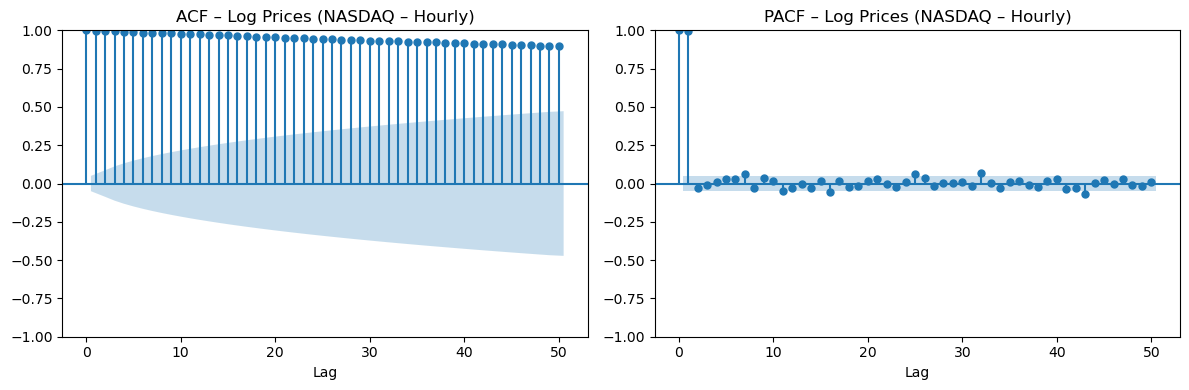

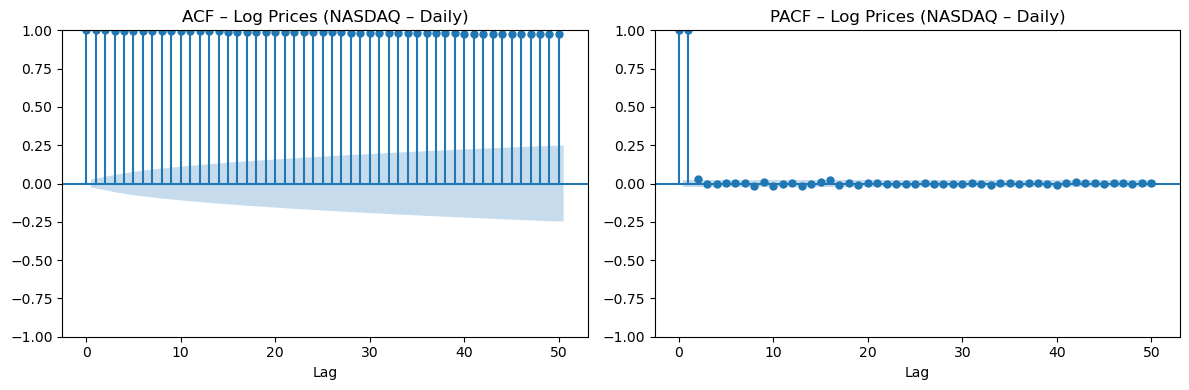

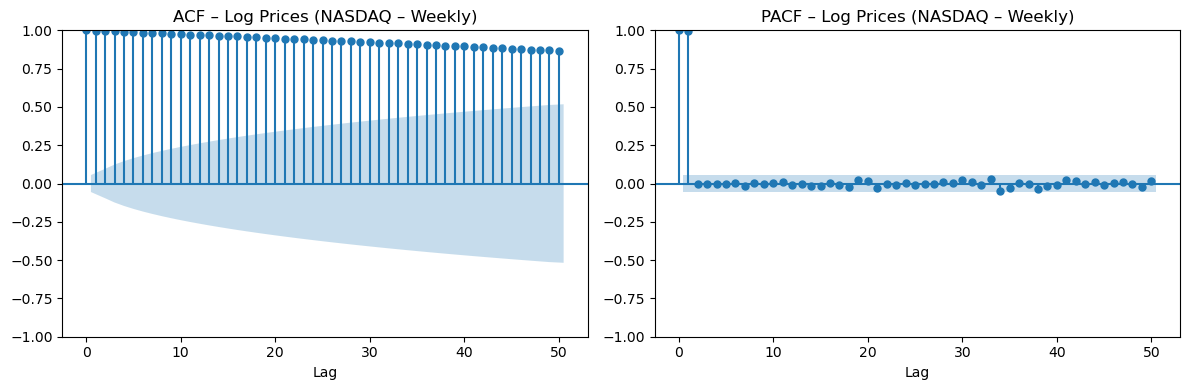

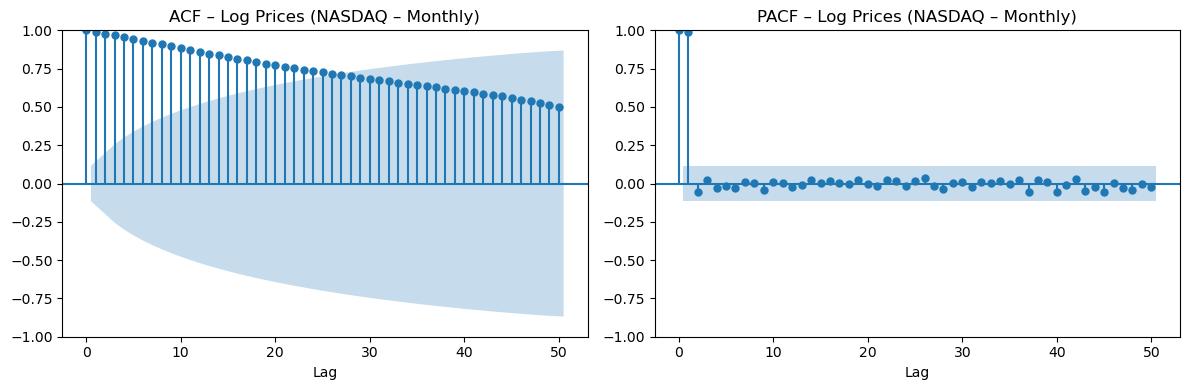

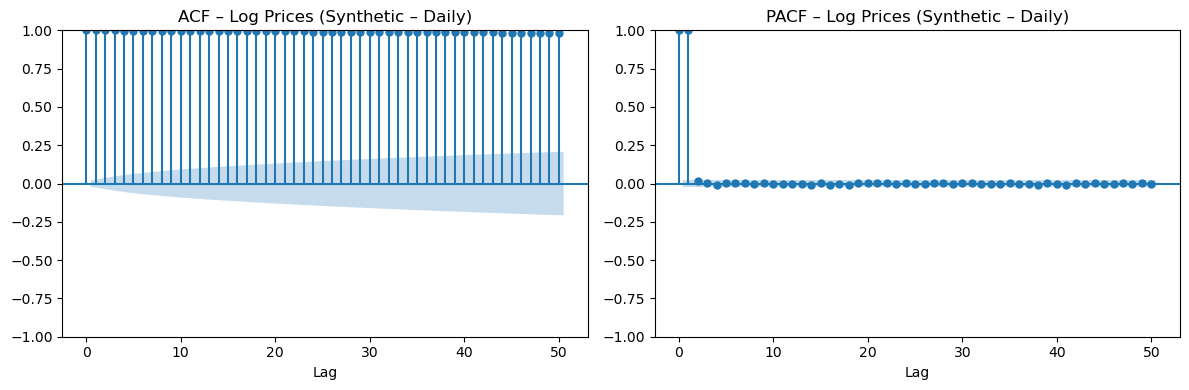

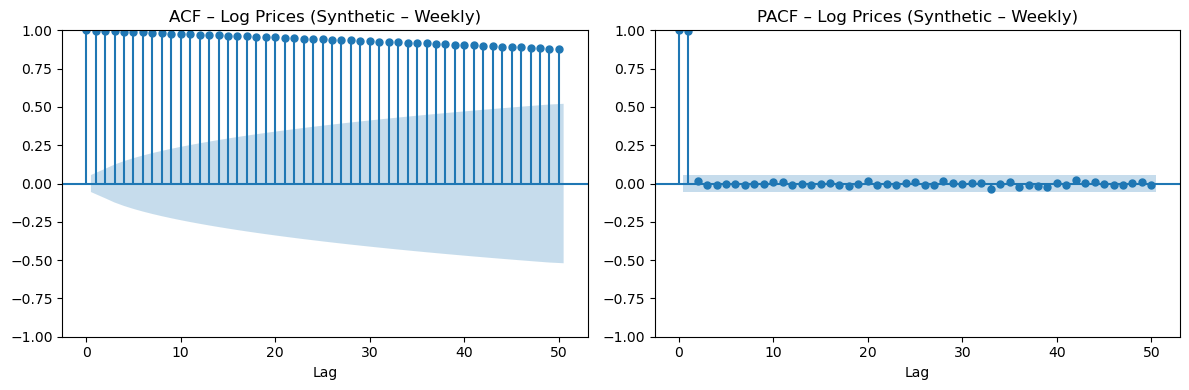

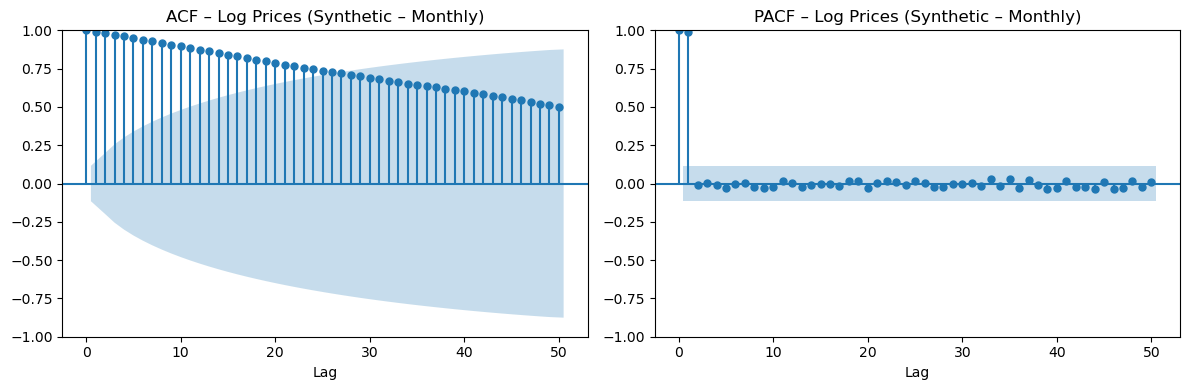

In [12]:
def plot_price_acf_pacf(obj, title, col=None, lags=50):
    """
    ACF and PACF of log prices to inspect persistence / unit-root behavior.

    obj  : Series or DataFrame containing log prices
    col  : optional column name if obj is a DataFrame
    lags : number of lags for ACF/PACF
    """
    y = extract_series(obj, col=col)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    plot_acf(y, ax=axes[0], lags=lags)
    axes[0].set_title(f"ACF – Log Prices ({title})")

    plot_pacf(y, ax=axes[1], lags=lags, method="ywm")
    axes[1].set_title(f"PACF – Log Prices ({title})")

    for ax in axes:
        ax.set_xlabel("Lag")

    plt.tight_layout()
    plt.show()

plot_price_acf_pacf(nasdaq_hourly_log_prices,   "NASDAQ – Hourly",  col="Log_Prices")
plot_price_acf_pacf(nasdaq_daily_log_prices,    "NASDAQ – Daily",   col="Log_Prices")
plot_price_acf_pacf(nasdaq_weekly_log_prices,   "NASDAQ – Weekly",  col="Log_Prices")
plot_price_acf_pacf(nasdaq_monthly_log_prices,  "NASDAQ – Monthly", col="Log_Prices")

plot_price_acf_pacf(synthetic_daily_log_prices,    "Synthetic – Daily",   col="Log_Prices")
plot_price_acf_pacf(synthetic_weekly_log_prices,   "Synthetic – Weekly",  col="Log_Prices")
plot_price_acf_pacf(synthetic_monthly_log_prices,  "Synthetic – Monthly", col="Log_Prices")

ACF fucntion for retunrs shows WHite Noise --> no correlations at all for all dates

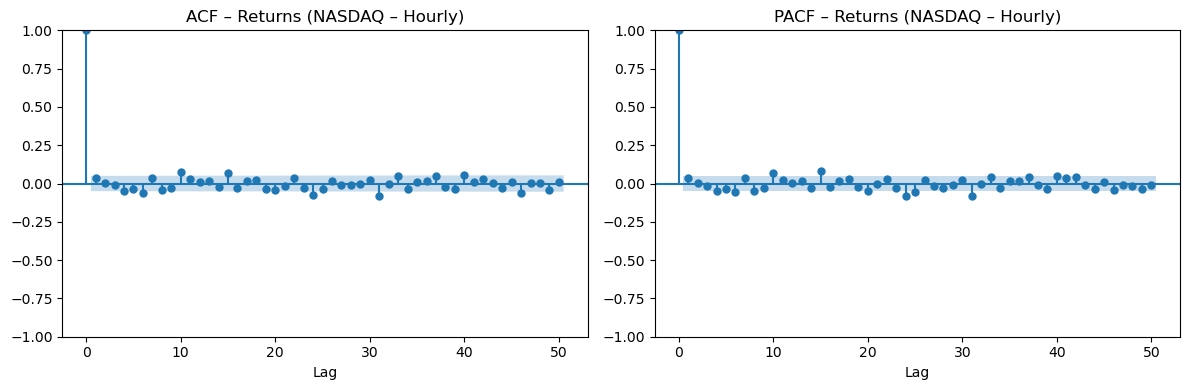

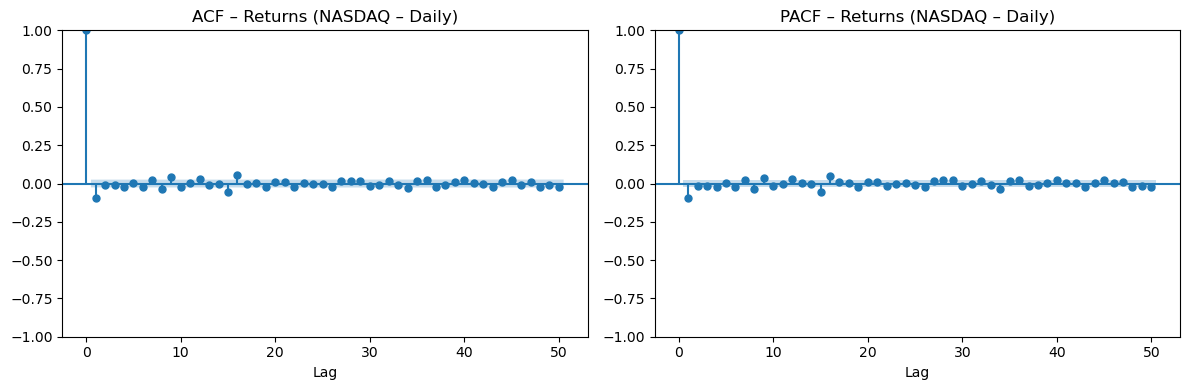

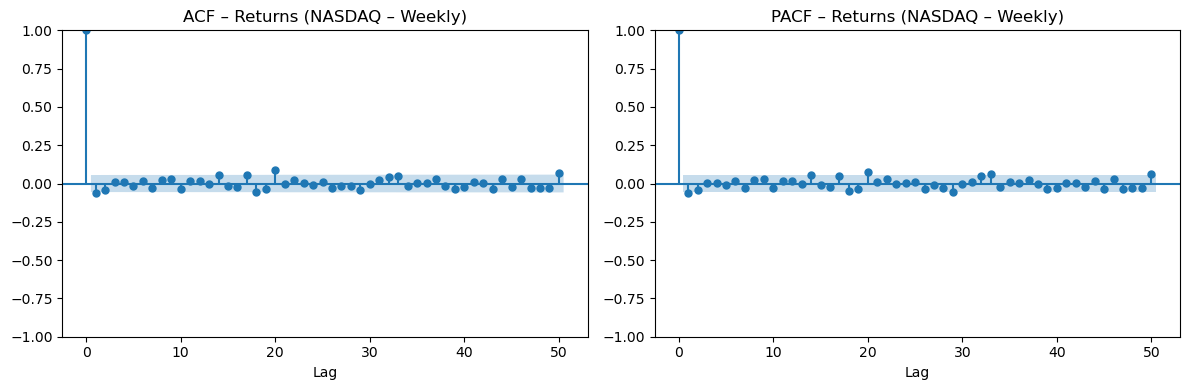

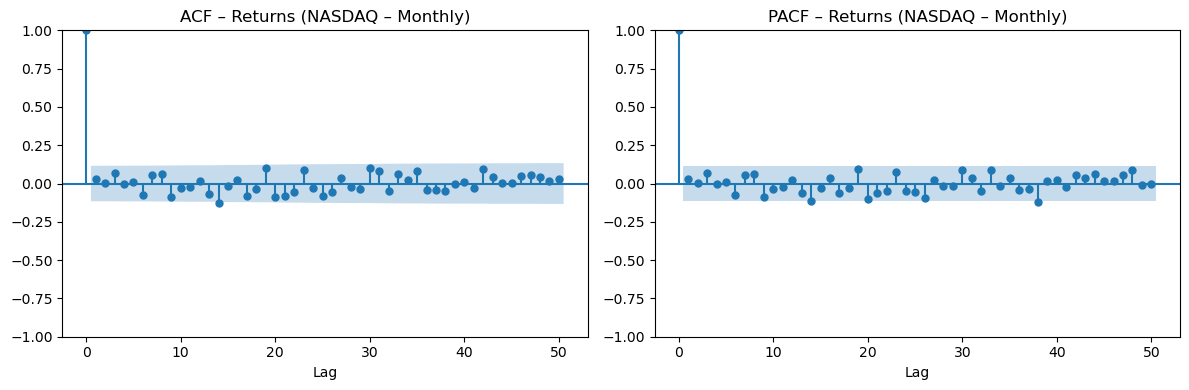

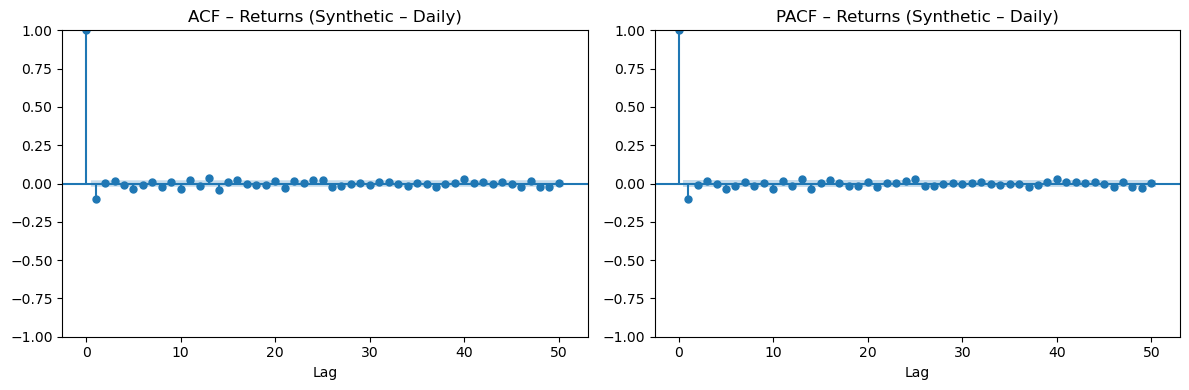

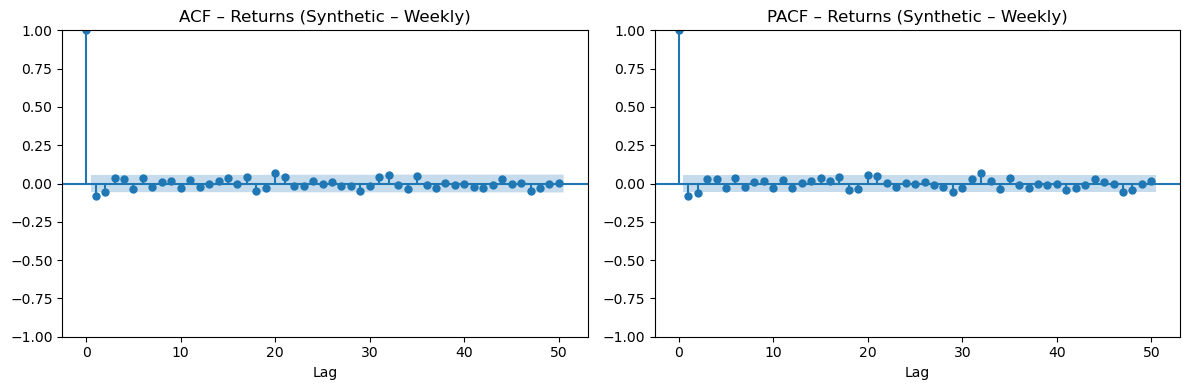

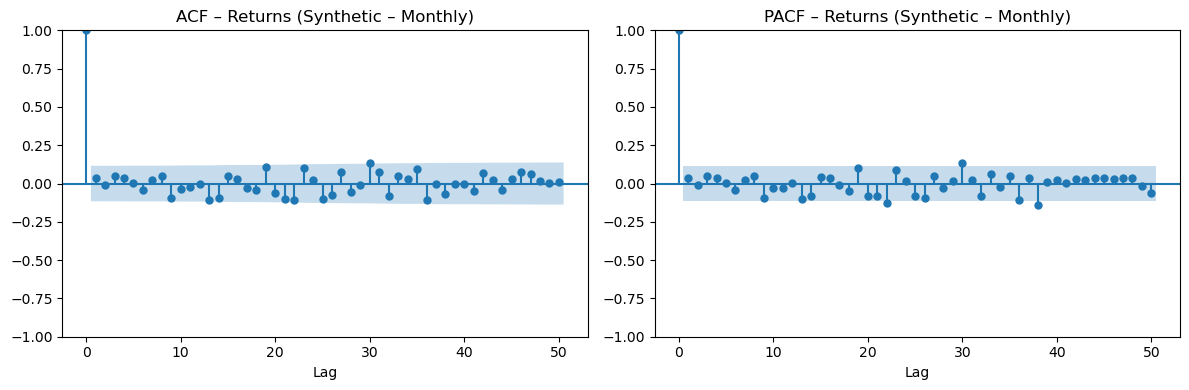

In [13]:
def extract_series(obj, col=None):
    """
    Take a Series or DataFrame and return a 1D Series.
    """
    if isinstance(obj, pd.Series):
        return obj.dropna()
    elif isinstance(obj, pd.DataFrame):
        if col is None:
            if obj.shape[1] != 1:
                raise ValueError("DataFrame has multiple columns, specify col='colname'.")
            return obj.iloc[:, 0].dropna()
        else:
            return obj[col].dropna()
    else:
        raise TypeError("obj must be a pandas Series or DataFrame")
    

def plot_return_acf_pacf(obj, title, col=None, lags=50):
    """
    ACF and PACF of log returns.
    Shows short memory & stationarity (RW2).
    """
    r = extract_series(obj, col=col)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    plot_acf(r, ax=axes[0], lags=lags)
    axes[0].set_title(f"ACF – Returns ({title})")

    plot_pacf(r, ax=axes[1], lags=lags, method="ywm")
    axes[1].set_title(f"PACF – Returns ({title})")

    for ax in axes:
        ax.set_xlabel("Lag")

    plt.tight_layout()
    plt.show()

plot_return_acf_pacf(nasdaq_hourly_log_returns,   "NASDAQ – Hourly",  col="Log_Returns")
plot_return_acf_pacf(nasdaq_daily_log_returns,    "NASDAQ – Daily",   col="Log_Returns")
plot_return_acf_pacf(nasdaq_weekly_log_returns,   "NASDAQ – Weekly",  col="Log_Returns")
plot_return_acf_pacf(nasdaq_monthly_log_returns,  "NASDAQ – Monthly", col="Log_Returns")

plot_return_acf_pacf(synthetic_daily_log_returns,    "Synthetic – Daily",   col="Log_Returns")
plot_return_acf_pacf(synthetic_weekly_log_returns,   "Synthetic – Weekly",  col="Log_Returns")
plot_return_acf_pacf(synthetic_monthly_log_returns,  "Synthetic – Monthly", col="Log_Returns")


Rolling ADF Plot --> Shows how non-stationarity evolves over time.

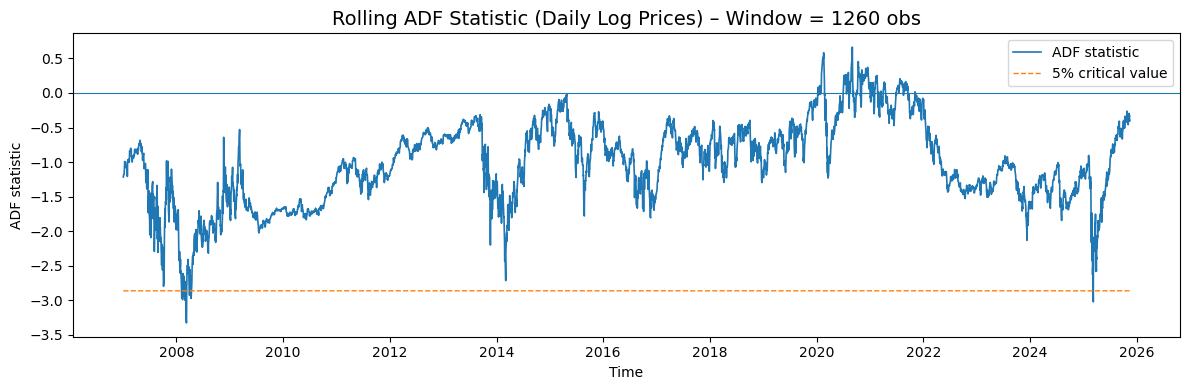

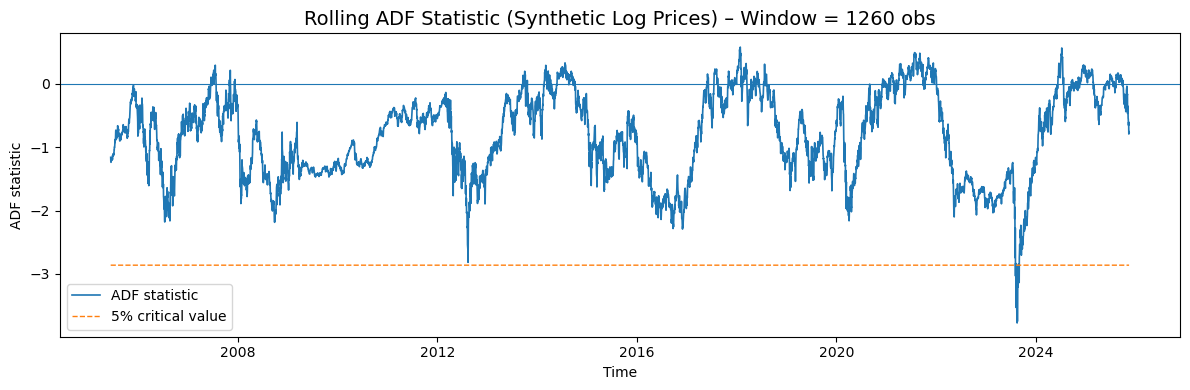

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

def extract_series(obj, col=None):
    if isinstance(obj, pd.Series):
        return obj.dropna()
    elif isinstance(obj, pd.DataFrame):
        if col is None:
            if obj.shape[1] != 1:
                raise ValueError("DataFrame has multiple columns, specify col='colname'.")
            return obj.iloc[:, 0].dropna()
        else:
            return obj[col].dropna()
    else:
        raise TypeError("obj must be a pandas Series or DataFrame")


def rolling_adf_plot(obj, title, col=None, window=750, maxlag=None):
    """
    Rolling ADF test on log prices.

    obj    : Series or DataFrame of (log) prices
    col    : column name if obj is a DataFrame
    window : window length in observations (set to 3–5 years in your units)
    maxlag : optional maxlag for adfuller (default None => autolag)
    """
    y = extract_series(obj, col=col)

    adf_stats = []
    crit_5_list = []
    idx = []

    for end in range(window, len(y) + 1):
        sub = y.iloc[end-window:end]
        try:
            res = adfuller(sub, maxlag=maxlag, autolag="AIC")
            stat = res[0]
            crit_5 = res[4]["5%"]
        except Exception:
            stat = np.nan
            crit_5 = np.nan
        adf_stats.append(stat)
        crit_5_list.append(crit_5)
        idx.append(sub.index[-1])  # align at window end

    roll_df = pd.DataFrame(
        {"adf_stat": adf_stats, "crit_5": crit_5_list},
        index=pd.Index(idx, name=y.index.name)
    )

    # ---- Plot ----
    plt.figure(figsize=(12, 4))
    plt.plot(roll_df.index, roll_df["adf_stat"], linewidth=1.2, label="ADF statistic")
    plt.plot(roll_df.index, roll_df["crit_5"], linestyle="--", linewidth=1.0,
             label="5% critical value")
    plt.axhline(0, linewidth=0.8)

    plt.title(f"Rolling ADF Statistic ({title}) – Window = {window} obs", fontsize=14)
    plt.xlabel("Time")
    plt.ylabel("ADF statistic")
    plt.legend()
    plt.tight_layout()
    plt.show()

rolling_adf_plot(nasdaq_daily_log_prices, "Daily Log Prices", window=1260)
rolling_adf_plot(synthetic_daily_log_prices, "Synthetic Log Prices", window = 1260)

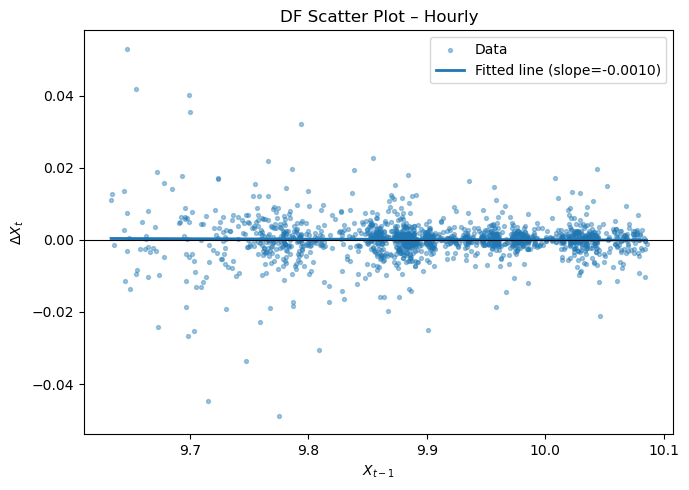

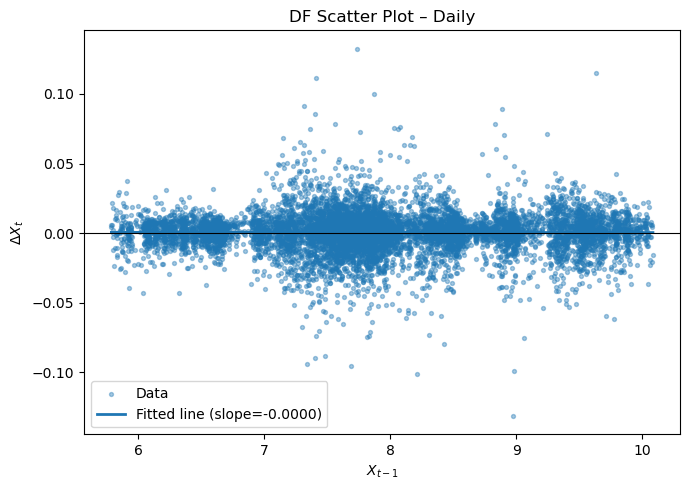

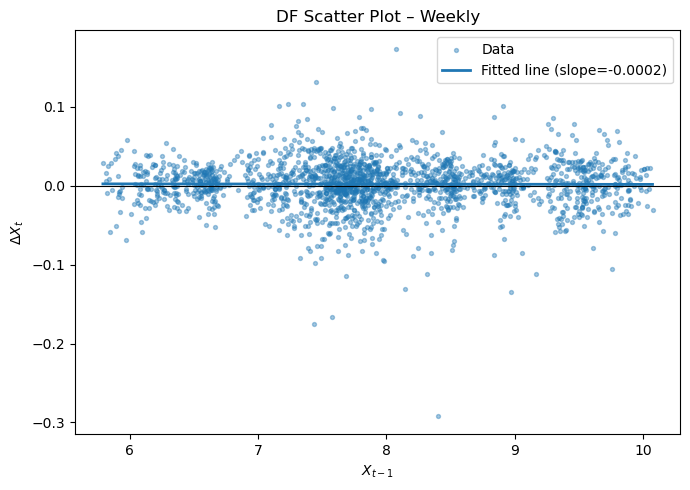

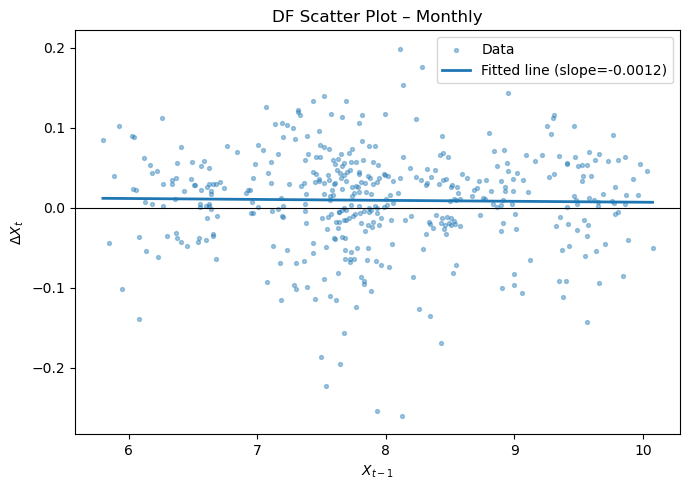

In [ ]:

def extract_series(obj, col=None):
    """
    Take a Series or DataFrame and return a 1D Series.
    """
    if isinstance(obj, pd.Series):
        return obj.dropna()
    elif isinstance(obj, pd.DataFrame):
        if col is None:
            if obj.shape[1] != 1:
                raise ValueError("DataFrame has multiple columns, specify col='colname'.")
            return obj.iloc[:, 0].dropna()
        else:
            return obj[col].dropna()
    else:
        raise TypeError("obj must be a pandas Series or DataFrame")


def df_scatter_plot(obj, title, col=None):
    """
    ΔX_t vs X_{t-1} scatter plot with OLS fitted line.
    Visualizes the Dickey–Fuller regression slope.
    """
    x = extract_series(obj, col=col)

    # Build X_{t-1} and ΔX_t
    x_lag = x.shift(1).dropna()
    dx = x.diff().dropna()

    # Align indices
    df = pd.DataFrame({"x_lag": x_lag, "dx": dx}).dropna()

    X = sm.add_constant(df["x_lag"])
    y = df["dx"]
    model = sm.OLS(y, X).fit()

    slope = model.params["x_lag"]
    intercept = model.params["const"]

    # ---- Plot ----
    plt.figure(figsize=(7, 5))
    plt.scatter(df["x_lag"], df["dx"], s=8, alpha=0.4, label="Data")

    # Fitted line
    x_vals = np.linspace(df["x_lag"].min(), df["x_lag"].max(), 200)
    y_hat = intercept + slope * x_vals
    plt.plot(x_vals, y_hat, linewidth=2, label=f"Fitted line (slope={slope:.4f})")

    plt.axhline(0, color="black", linewidth=0.8)
    plt.xlabel(r"$X_{t-1}$")
    plt.ylabel(r"$\Delta X_t$")
    plt.title(f"DF Scatter Plot – {title}")
    plt.legend()
    plt.tight_layout()
    plt.show()

df_scatter_plot(nasdaq_hourly_log_prices,   "NASDAQ – Hourly",  col="Log_Prices")
df_scatter_plot(nasdaq_daily_log_prices,    "NASDAQ – Daily",   col="Log_Prices")
df_scatter_plot(nasdaq_weekly_log_prices,   "NASDAQ – Weekly",  col="Log_Prices")
df_scatter_plot(nasdaq_monthly_log_prices,  "NASDAQ – Monthly", col="Log_Prices")

df_scatter_plot(synthetic_daily_log_prices,    "Synthetic – Daily",   col="Log_Prices")
df_scatter_plot(synthetic_weekly_log_prices,   "Synthetic – Weekly",  col="Log_Prices")
df_scatter_plot(synthetic_monthly_log_prices,  "Synthetic – Monthly", col="Log_Prices")


White noise Returns Plots ---> If ACFs lie inside 95% CI → martingale difference sequence.

<Figure size 800x400 with 0 Axes>

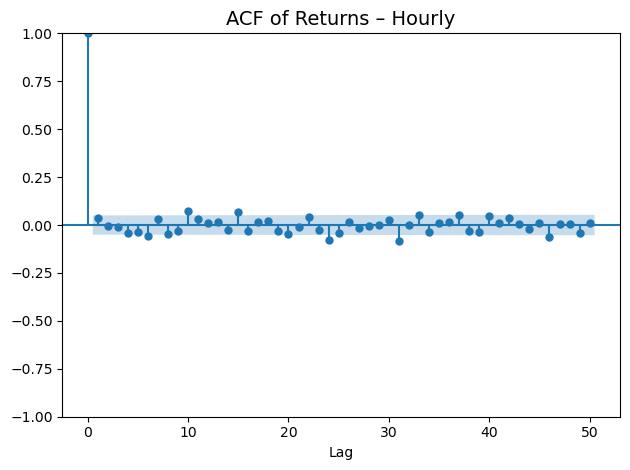

<Figure size 800x400 with 0 Axes>

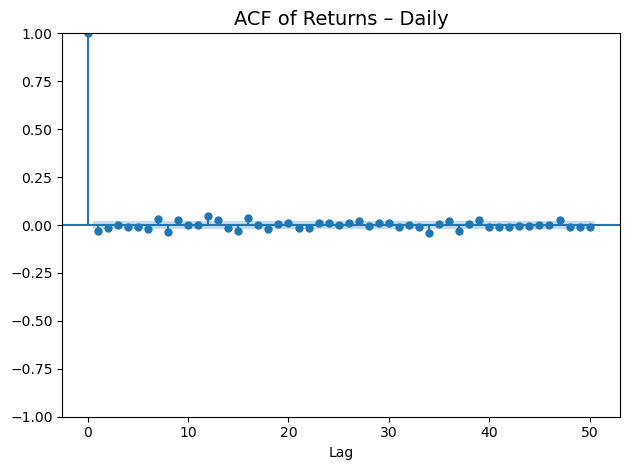

<Figure size 800x400 with 0 Axes>

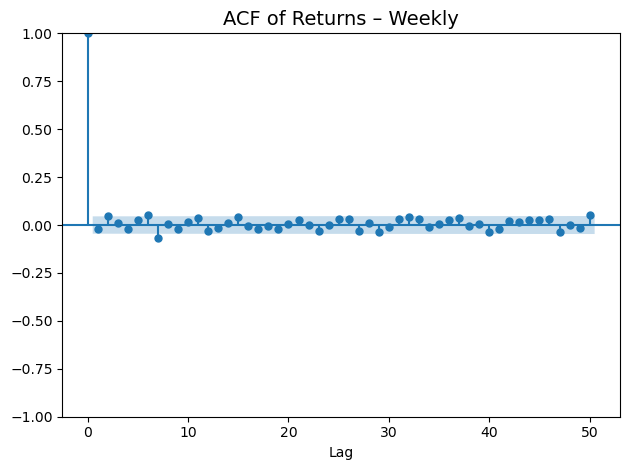

<Figure size 800x400 with 0 Axes>

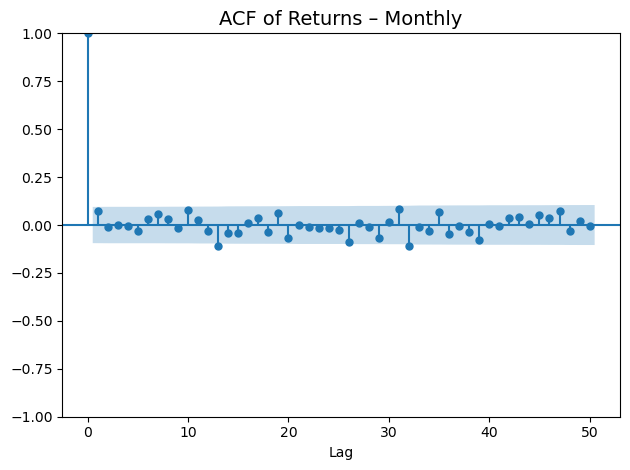

In [46]:
def extract_series(obj, col=None):
    """
    Take a Series or DataFrame and return a 1D Series.
    """
    if isinstance(obj, pd.Series):
        return obj.dropna()
    elif isinstance(obj, pd.DataFrame):
        if col is None:
            if obj.shape[1] != 1:
                raise ValueError(
                    "DataFrame has multiple columns, specify col='colname'."
                )
            return obj.iloc[:, 0].dropna()
        else:
            return obj[col].dropna()
    else:
        raise TypeError("obj must be a pandas Series or DataFrame")


def plot_return_acf(obj, title, col=None, lags=50):
    """
    ACF of returns with 95% CI.
    If all autocorrelations lie inside the CI → martingale difference.
    """
    r = extract_series(obj, col=col)

    plt.figure(figsize=(8, 4))
    plot_acf(r, lags=lags)
    plt.title(f"ACF of Returns – {title}", fontsize=14)
    plt.xlabel("Lag")
    plt.tight_layout()
    plt.show()
    

plot_return_acf(nasdaq_hourly_df_log_returns,  "Hourly",  col="Log_Returns")
plot_return_acf(nasdaq_daily_log_returns,   "Daily",   col="Log_Returns")
plot_return_acf(nasdaq_weekly_log_returns,  "Weekly",  col="Log_Returns")
plot_return_acf(nasdaq_monthly_log_returns, "Monthly", col="Log_Returns")

Ljung - Box- P-value Plot --> Seeing all p-values at once is much clearer. Reject RW3 if many p-values < 0.05.

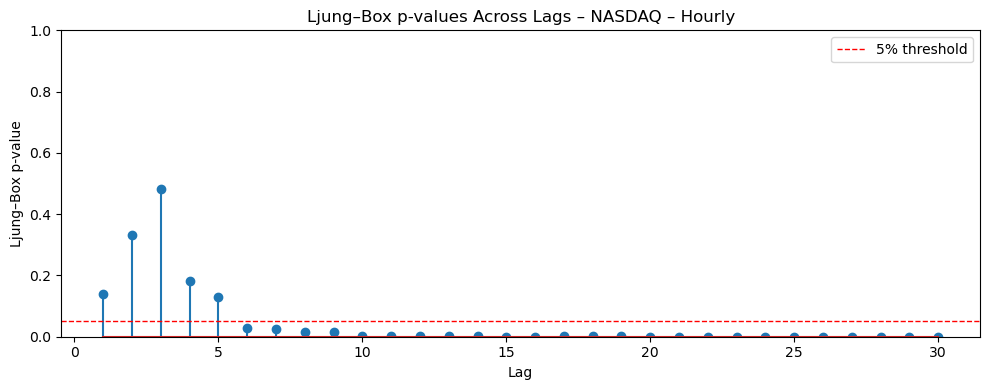

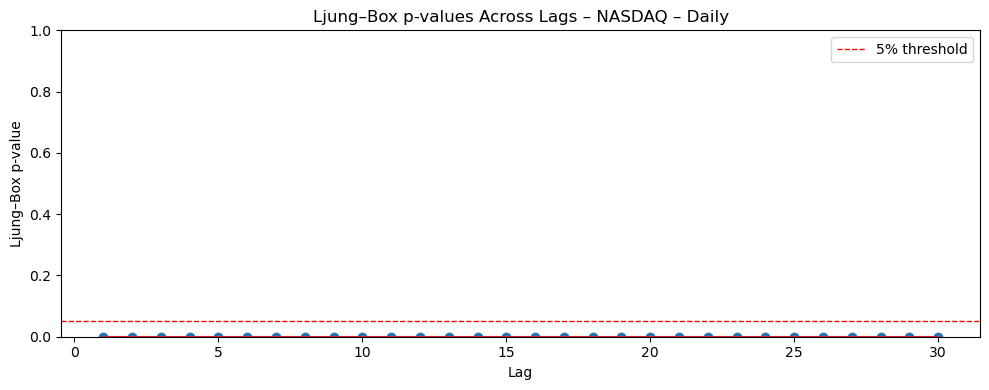

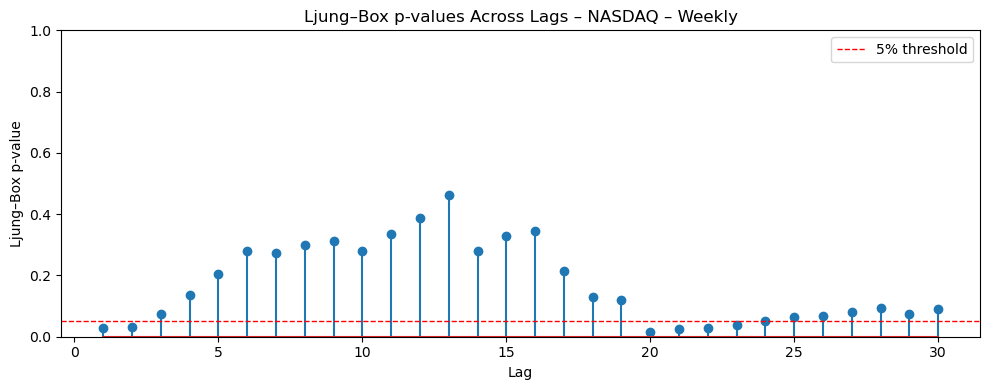

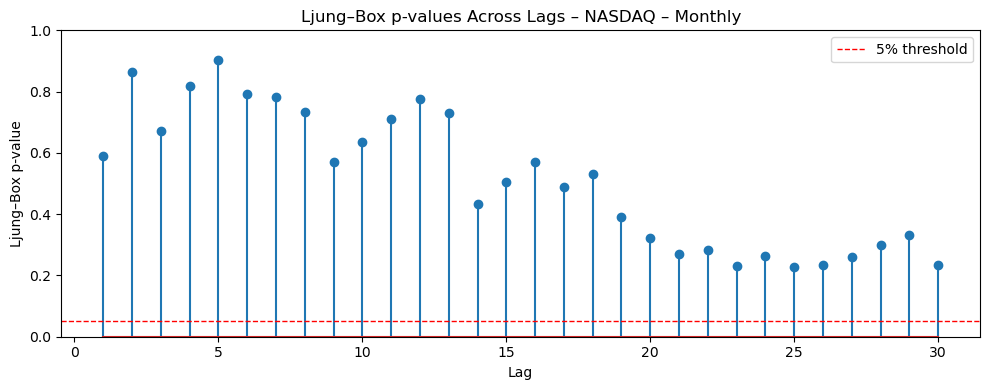

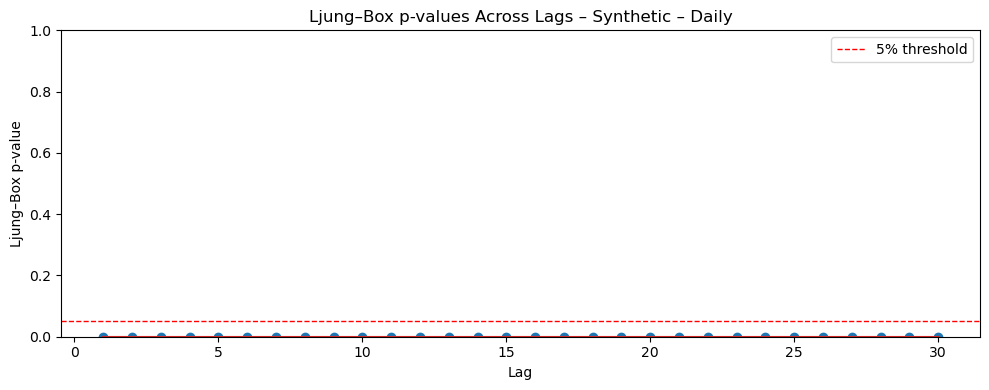

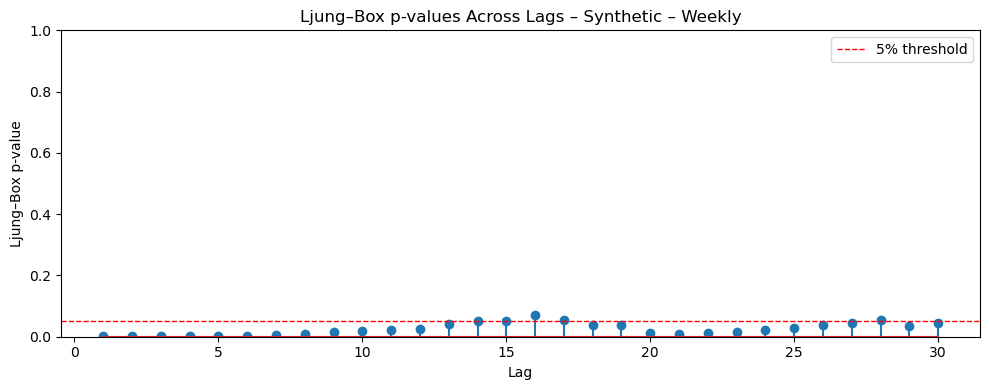

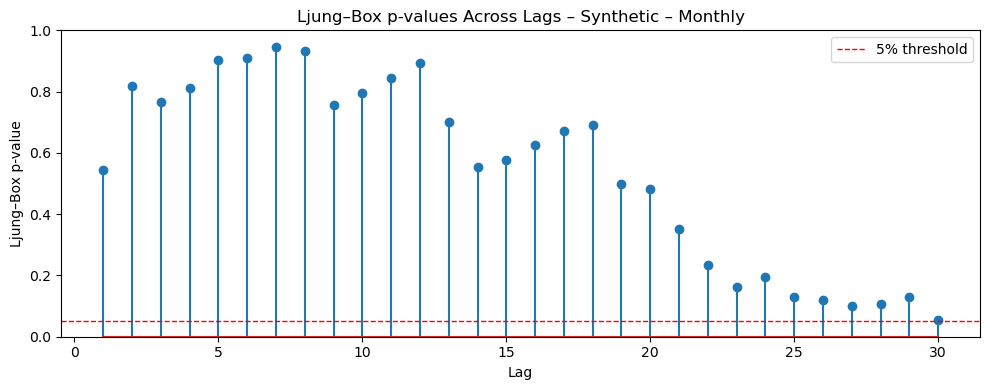

In [15]:
def ljung_box_pvalue_plot(obj, title, col=None, max_lag=30):
    """
    Ljung–Box p-value plot for lags 1 to max_lag.
    Reject RW3 if p-values < 0.05.
    """
    r = extract_series(obj, col=col)

    lb = acorr_ljungbox(r, lags=list(range(1, max_lag + 1)), return_df=True)
    pvals = lb["lb_pvalue"].values
    lags = np.arange(1, max_lag + 1)

    plt.figure(figsize=(10, 4))
    # OLD (breaks on your version):
    # plt.stem(lags, pvals, use_line_collection=True)
    # NEW:
    plt.stem(lags, pvals)

    plt.axhline(0.05, color="red", linestyle="--", linewidth=1, label="5% threshold")
    plt.ylim(0, 1)
    plt.xlabel("Lag")
    plt.ylabel("Ljung–Box p-value")
    plt.title(f"Ljung–Box p-values Across Lags – {title}")
    plt.legend()
    plt.tight_layout()
    plt.show()

ljung_box_pvalue_plot(nasdaq_hourly_log_returns,   "NASDAQ – Hourly",  col="Log_Returns")
ljung_box_pvalue_plot(nasdaq_daily_log_returns,    "NASDAQ – Daily",   col="Log_Returns")
ljung_box_pvalue_plot(nasdaq_weekly_log_returns,   "NASDAQ – Weekly",  col="Log_Returns")
ljung_box_pvalue_plot(nasdaq_monthly_log_returns,  "NASDAQ – Monthly", col="Log_Returns")

ljung_box_pvalue_plot(synthetic_daily_log_returns,    "Synthetic – Daily",   col="Log_Returns")
ljung_box_pvalue_plot(synthetic_weekly_log_returns,   "Synthetic – Weekly",  col="Log_Returns")
ljung_box_pvalue_plot(synthetic_monthly_log_returns,  "Synthetic – Monthly", col="Log_Returns")

